Integral of the Gaussian kernel for dx=0.0025: 0.9999999999999999
Integral of the Gaussian kernel for dx=0.005: 1.0
Integral of the Gaussian kernel for dx=0.0075: 1.0
Integral of the Gaussian kernel for dx=0.01: 1.0
Integral of the Gaussian kernel for dx=0.015: 1.0


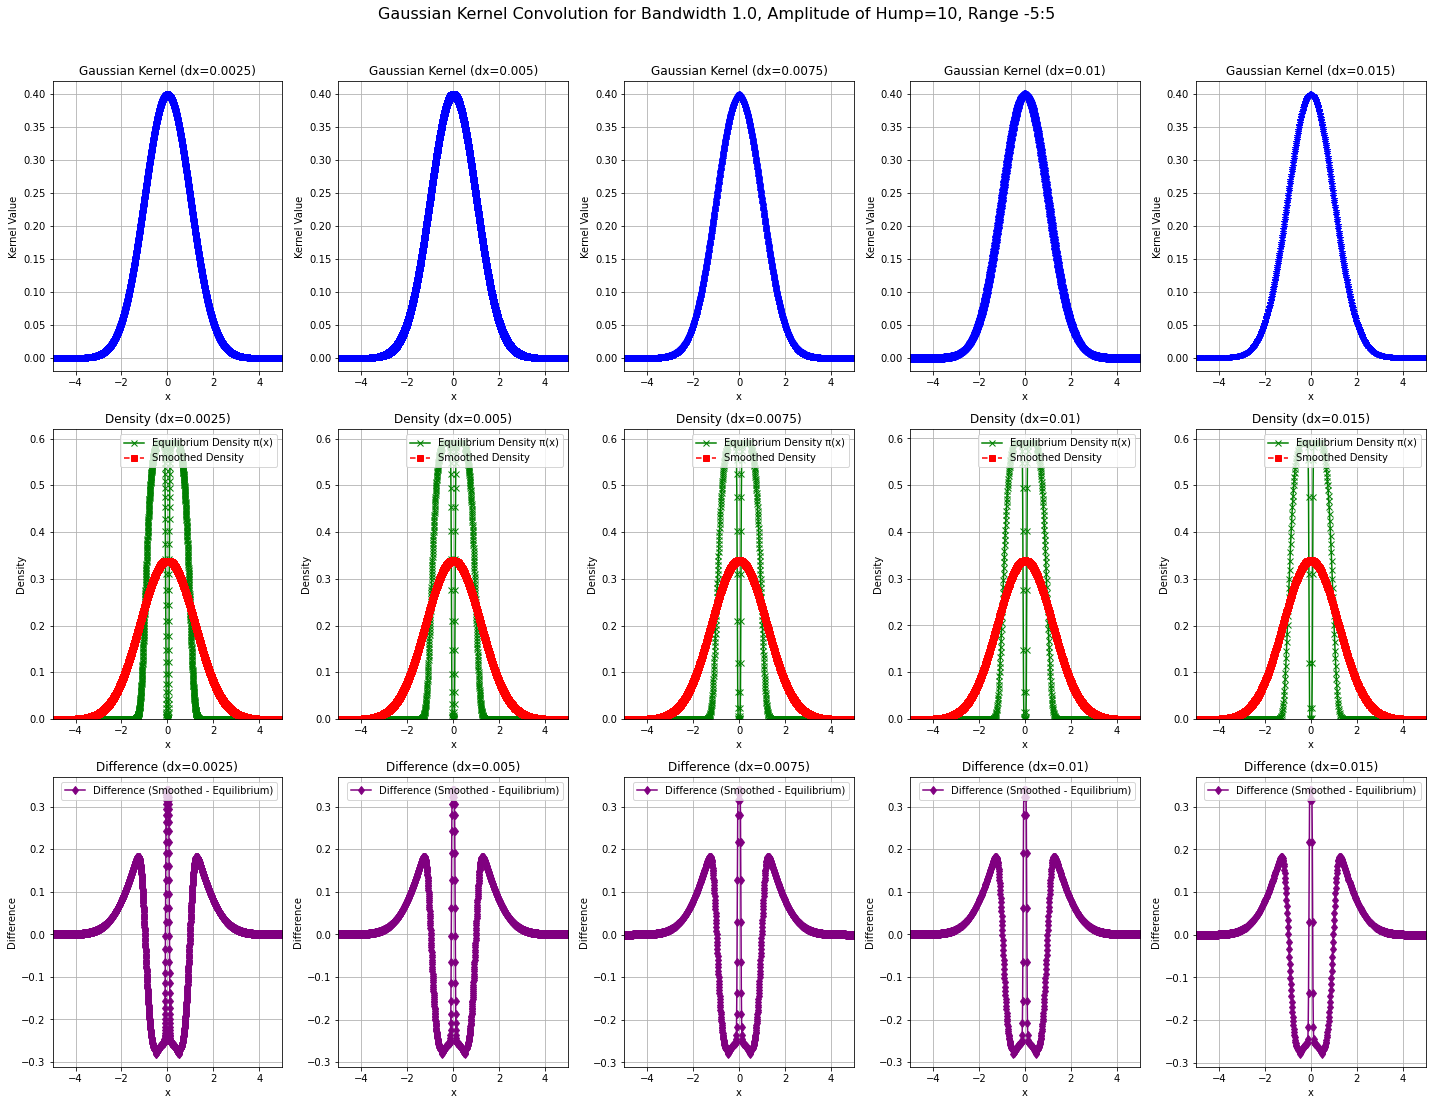

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# New Potential Function V(x)
def V(x, sigma_pot=0.05, y0=0.1, A=10.0, a=1.0, x_c=0.5):
    """
    Computes the 1D potential function mimicking the 2D entropic double-well potential.

    Parameters:
    - x: The position at which to evaluate the potential.
    - sigma_pot: The width of the barrier, controls the sharpness of the hump.
    - y0: The y-parameter of the original 2D potential, kept constant here.
    - A: Amplitude of the middle hump.
    - a: Scaling factor for the potential.
    - x_c: Critical value where the function transitions from inside to outside the barrier.

    Returns:
    - V(x): The potential value at position x.
    """
    if np.abs(x) > x_c:
        # Outside the barrier region; the potential grows like x^6
        return a * x**6
    else:
        # Inside the barrier region; use a Gaussian-like function to create the middle hump
        return A * np.exp(-(x/sigma_pot)**2) * (1 - np.exp(-(y0/sigma_pot)**2))

def gaussian_kernel(x, sigma_kernel):
    """Gaussian Kernel function."""
    coeff = 1.0 / (np.sqrt(2.0 * np.pi) * sigma_kernel)
    exponent = -0.5 * (x**2) / (sigma_kernel**2)
    return coeff * np.exp(exponent)

def convolve_density(boltz_array, kernel_array, dx):
    """Perform convolution on the density array."""
    npoints_pot = len(boltz_array)
    npoints_kernel = len(kernel_array)
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half = (npoints_kernel - 1) // 2
    
    for kount in range(npoints_pot):
        for kount_kernel in range(npoints_kernel):
            kount_kernel_shifted = kount - kernel_half + kount_kernel
            if 0 <= kount_kernel_shifted < npoints_pot:
                boltz_array_conv[kount_kernel_shifted] += boltz_array[kount] * kernel_array[kount_kernel] * dx
    
    return boltz_array_conv

def plot_results(lattice_spacings, sigma_kernel, x_min, x_max):
    fig, axs = plt.subplots(3, len(lattice_spacings), figsize=(20, 15))
    
    # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    markers = ['o', 's', '^', 'D', '*']  # Different markers for different plots
    colors = ['orange', 'green', 'red', 'purple', 'blue']  # Different colors for different plots

    for i, dx in enumerate(lattice_spacings):
        npoints_pot = int((x_max - x_min - 0.1 * dx) / dx) + 2
        x = np.linspace(x_min, x_max, npoints_pot)

        potential_array = np.array([V(xi) for xi in x])
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density using the trapezium rule
        boltz_array /= np.trapz(boltz_array, x)
        
        # Kernel and its convolution
        # Extend Kernel to cover 5*sigma_kernel
        kernel_size = int(5 * sigma_kernel)  # Extending kernel size
        npoints_kernel = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel = 2 * npoints_kernel + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel)
        kernel_array = np.array([gaussian_kernel(kx, sigma_kernel) for kx in kernel_x])
        
        # Normalize the kernel using the trapezium rule
        kernel_integral = np.trapz(kernel_array, kernel_x)
        kernel_array /= kernel_integral
        
        # Print the integral of the kernel to check if it is equal to one
        print(f'Integral of the Gaussian kernel for dx={dx}: {np.trapz(kernel_array, kernel_x)}')
        
        boltz_array_conv = convolve_density(boltz_array, kernel_array, dx)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Gaussian Kernel
        axs[0, i].plot(kernel_x, kernel_array, color='blue', marker=markers[i % len(markers)])
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('Kernel Value')
        axs[0, i].set_title(f'Gaussian Kernel (dx={dx})')
        axs[0, i].grid(True)
        axs[0, i].set_xlim(-kernel_size, kernel_size)  # Updated to 5*sigma_kernel
        
        # Plot Equilibrium Density and Smoothed Density
        axs[1, i].plot(x, boltz_array, label='Equilibrium Density π(x)', color='green', marker='x')
        axs[1, i].plot(x, boltz_array_conv, label='Smoothed Density', color='red', linestyle='--', marker='s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Density')
        axs[1, i].set_title(f'Density (dx={dx})')
        axs[1, i].legend()
        axs[1, i].grid(True)
        axs[1, i].set_xlim(x_min, x_max)
        axs[1, i].set_ylim(bottom=0)  # Ensure densities start from zero
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[2, i].plot(x, density_difference, label='Difference (Smoothed - Equilibrium)', color='purple', marker='d')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('Difference')
        axs[2, i].set_title(f'Difference (dx={dx})')
        axs[2, i].legend()
        axs[2, i].grid(True)
        axs[2, i].set_xlim(x_min, x_max)
        
    # Add a main title to the figure
    fig.suptitle('Gaussian Kernel Convolution for Bandwidth 1.0, Amplitude of Hump=10, Range -5:5', fontsize=16, y=1.02)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig('GK_1d2d_a10_bw1.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.0025, 0.005, 0.0075, 0.01, 0.015]  # Finer lattice spacings
    sigma_kernel = 1.0  # Fixed bandwidth for Gaussian kernel
    x_min, x_max = -5, 5  # Keeping the x range as -5 to 5
    plot_results(lattice_spacings, sigma_kernel, x_min, x_max)


Integral of the Gaussian kernel for dx=0.0025: 1.0
Integral of the Gaussian kernel for dx=0.005: 1.0
Integral of the Gaussian kernel for dx=0.0075: 1.0
Integral of the Gaussian kernel for dx=0.01: 1.0
Integral of the Gaussian kernel for dx=0.015: 1.0


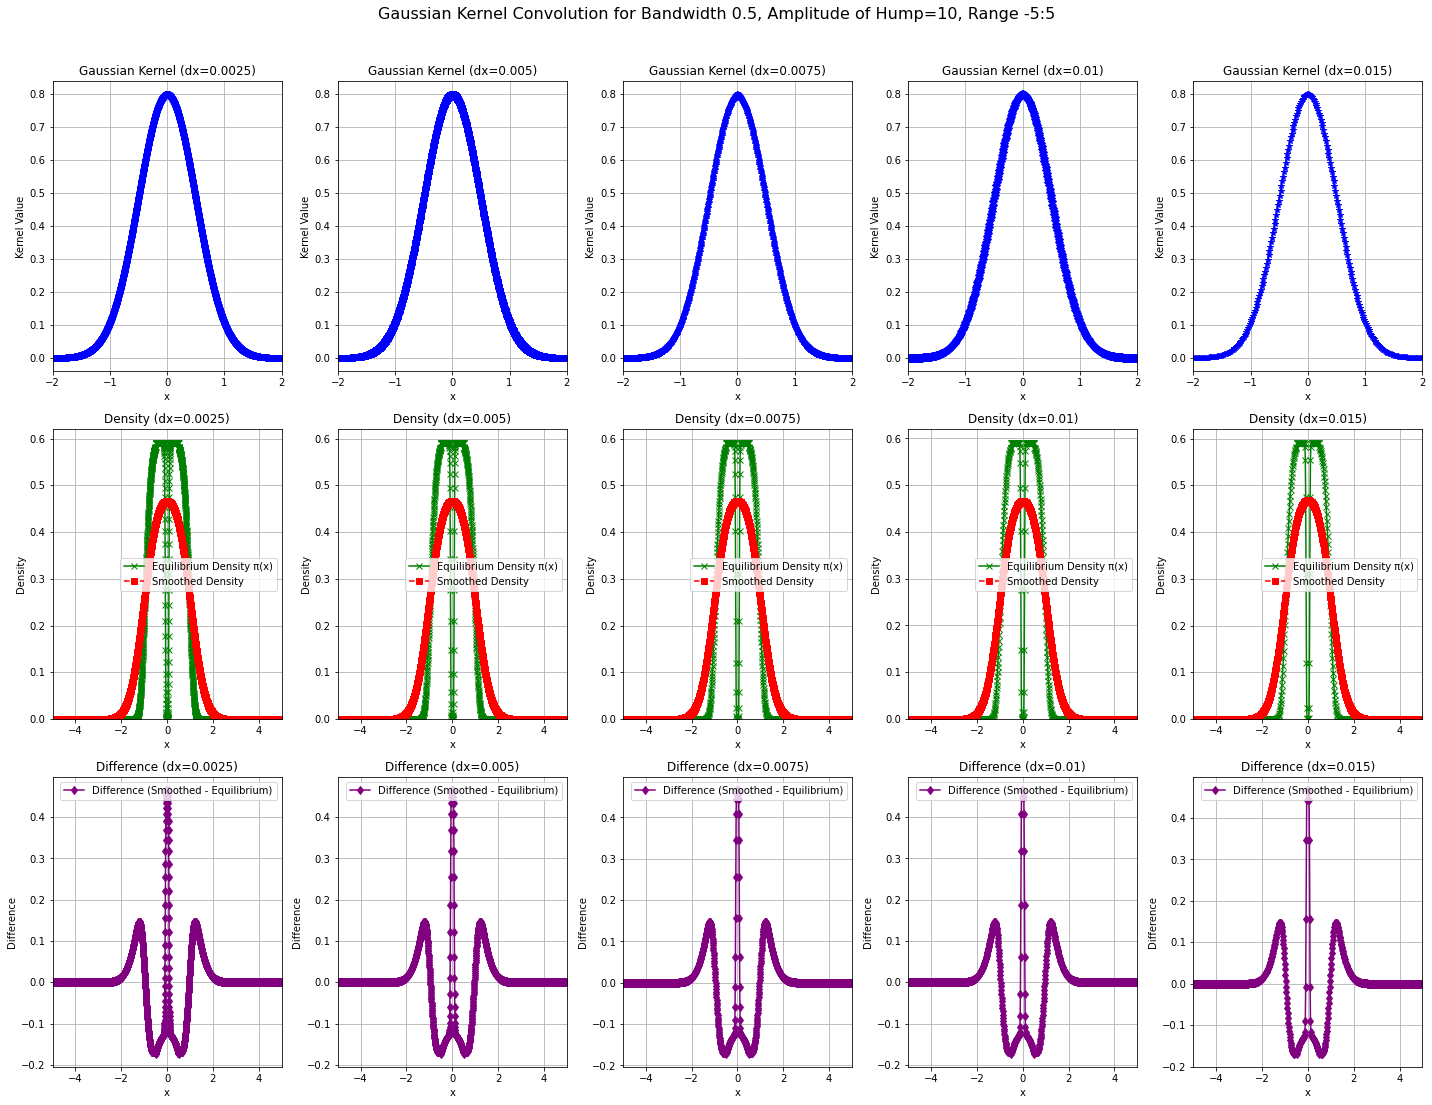

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# New Potential Function V(x)
def V(x, sigma_pot=0.05, y0=0.1, A=10.0, a=1.0, x_c=0.5):
    """
    Computes the 1D potential function mimicking the 2D entropic double-well potential.

    Parameters:
    - x: The position at which to evaluate the potential.
    - sigma_pot: The width of the barrier, controls the sharpness of the hump.
    - y0: The y-parameter of the original 2D potential, kept constant here.
    - A: Amplitude of the middle hump.
    - a: Scaling factor for the potential.
    - x_c: Critical value where the function transitions from inside to outside the barrier.

    Returns:
    - V(x): The potential value at position x.
    """
    if np.abs(x) > x_c:
        # Outside the barrier region; the potential grows like x^6
        return a * x**6
    else:
        # Inside the barrier region; use a Gaussian-like function to create the middle hump
        return A * np.exp(-(x/sigma_pot)**2) * (1 - np.exp(-(y0/sigma_pot)**2))

def gaussian_kernel(x, sigma_kernel):
    """Gaussian Kernel function."""
    coeff = 1.0 / (np.sqrt(2.0 * np.pi) * sigma_kernel)
    exponent = -0.5 * (x**2) / (sigma_kernel**2)
    return coeff * np.exp(exponent)

def convolve_density(boltz_array, kernel_array, dx):
    """Perform convolution on the density array."""
    npoints_pot = len(boltz_array)
    npoints_kernel = len(kernel_array)
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half = (npoints_kernel - 1) // 2
    
    for kount in range(npoints_pot):
        for kount_kernel in range(npoints_kernel):
            kount_kernel_shifted = kount - kernel_half + kount_kernel
            if 0 <= kount_kernel_shifted < npoints_pot:
                boltz_array_conv[kount_kernel_shifted] += boltz_array[kount] * kernel_array[kount_kernel] * dx
    
    return boltz_array_conv

def plot_results(lattice_spacings, sigma_kernel, x_min, x_max):
    fig, axs = plt.subplots(3, len(lattice_spacings), figsize=(20, 15))
    
    # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    markers = ['o', 's', '^', 'D', '*']  # Different markers for different plots
    colors = ['orange', 'green', 'red', 'purple', 'blue']  # Different colors for different plots

    for i, dx in enumerate(lattice_spacings):
        npoints_pot = int((x_max - x_min - 0.1 * dx) / dx) + 2
        x = np.linspace(x_min, x_max, npoints_pot)

        potential_array = np.array([V(xi) for xi in x])
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density using the trapezium rule
        boltz_array /= np.trapz(boltz_array, x)
        
        # Kernel and its convolution
        # Extend Kernel to cover 5*sigma_kernel
        kernel_size = int(5 * sigma_kernel)  # Extending kernel size
        npoints_kernel = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel = 2 * npoints_kernel + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel)
        kernel_array = np.array([gaussian_kernel(kx, sigma_kernel) for kx in kernel_x])
        
        # Normalize the kernel using the trapezium rule
        kernel_integral = np.trapz(kernel_array, kernel_x)
        kernel_array /= kernel_integral
        
        # Print the integral of the kernel to check if it is equal to one
        print(f'Integral of the Gaussian kernel for dx={dx}: {np.trapz(kernel_array, kernel_x)}')
        
        boltz_array_conv = convolve_density(boltz_array, kernel_array, dx)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Gaussian Kernel
        axs[0, i].plot(kernel_x, kernel_array, color='blue', marker=markers[i % len(markers)])
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('Kernel Value')
        axs[0, i].set_title(f'Gaussian Kernel (dx={dx})')
        axs[0, i].grid(True)
        axs[0, i].set_xlim(-kernel_size, kernel_size)  # Updated to 5*sigma_kernel
        
        # Plot Equilibrium Density and Smoothed Density
        axs[1, i].plot(x, boltz_array, label='Equilibrium Density π(x)', color='green', marker='x')
        axs[1, i].plot(x, boltz_array_conv, label='Smoothed Density', color='red', linestyle='--', marker='s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Density')
        axs[1, i].set_title(f'Density (dx={dx})')
        axs[1, i].legend()
        axs[1, i].grid(True)
        axs[1, i].set_xlim(x_min, x_max)
        axs[1, i].set_ylim(bottom=0)  # Ensure densities start from zero
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[2, i].plot(x, density_difference, label='Difference (Smoothed - Equilibrium)', color='purple', marker='d')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('Difference')
        axs[2, i].set_title(f'Difference (dx={dx})')
        axs[2, i].legend()
        axs[2, i].grid(True)
        axs[2, i].set_xlim(x_min, x_max)
        
    # Add a main title to the figure
    fig.suptitle('Gaussian Kernel Convolution for Bandwidth 0.5, Amplitude of Hump=10, Range -5:5', fontsize=16, y=1.02)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig('GK_1d2d_a10_bwo5.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.0025, 0.005, 0.0075, 0.01, 0.015]  # Finer lattice spacings
    sigma_kernel = 0.5  # Fixed bandwidth for Gaussian kernel
    x_min, x_max = -5, 5  # Keeping the x range as -5 to 5
    plot_results(lattice_spacings, sigma_kernel, x_min, x_max)


Integral of the Gaussian kernel for dx=0.0025: 1.0
Integral of the Gaussian kernel for dx=0.005: 1.0
Integral of the Gaussian kernel for dx=0.0075: 1.0
Integral of the Gaussian kernel for dx=0.01: 1.0
Integral of the Gaussian kernel for dx=0.015: 1.0000000000000002


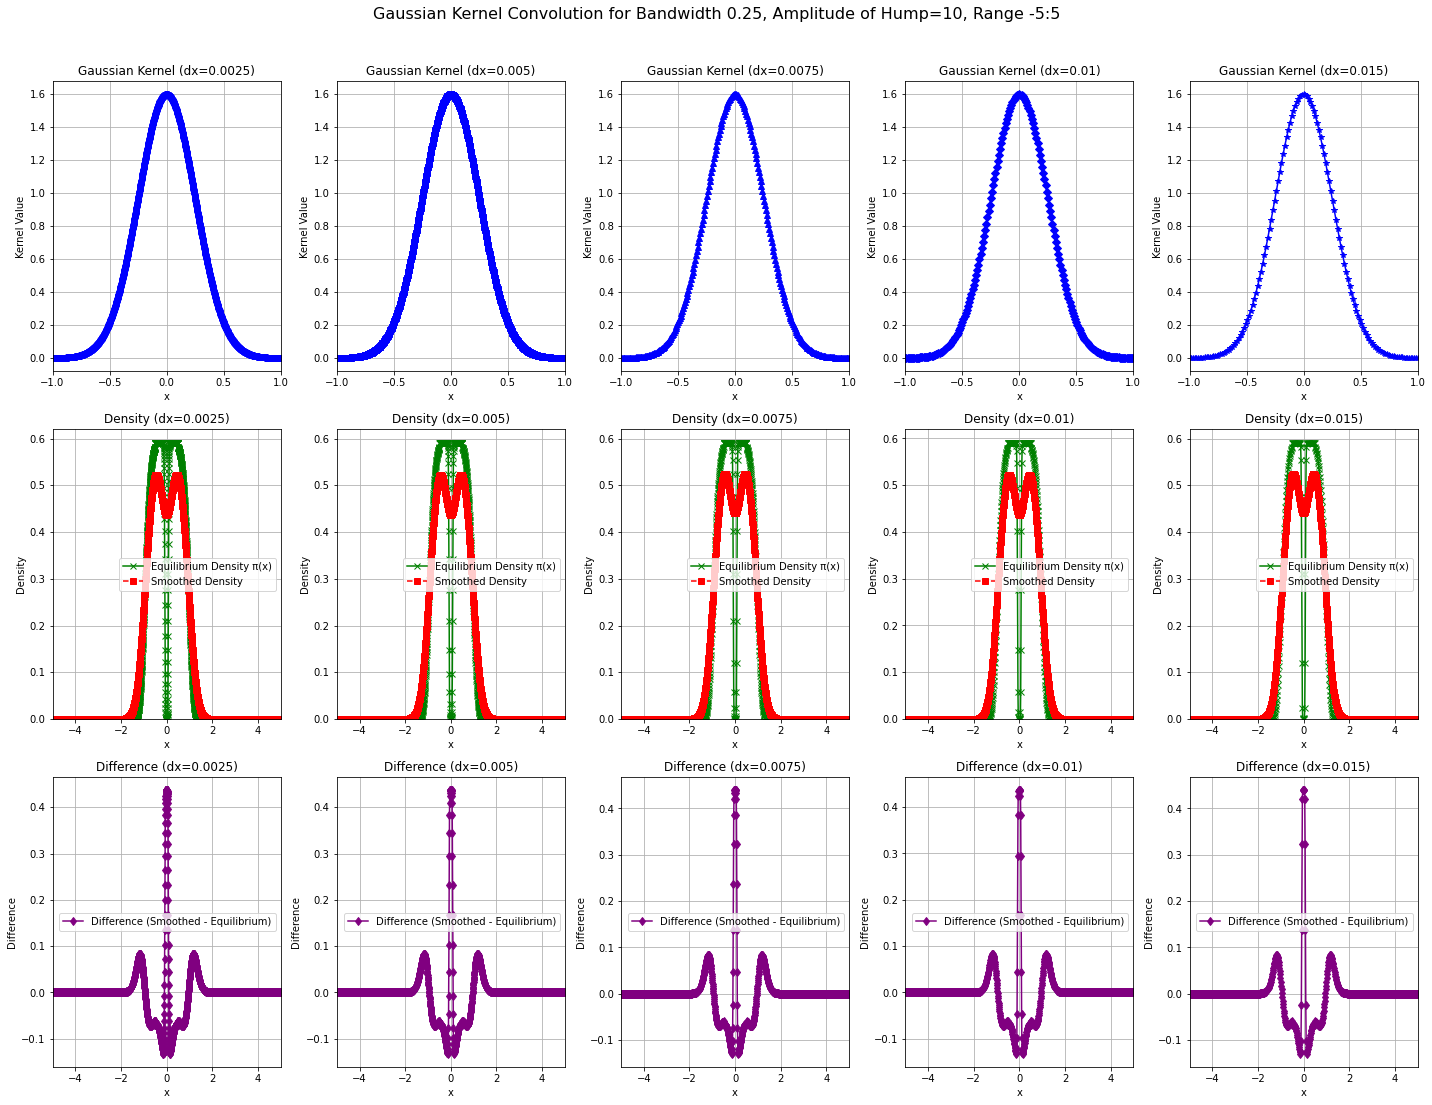

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# New Potential Function V(x)
def V(x, sigma_pot=0.05, y0=0.1, A=10.0, a=1.0, x_c=0.5):
    """
    Computes the 1D potential function mimicking the 2D entropic double-well potential.

    Parameters:
    - x: The position at which to evaluate the potential.
    - sigma_pot: The width of the barrier, controls the sharpness of the hump.
    - y0: The y-parameter of the original 2D potential, kept constant here.
    - A: Amplitude of the middle hump.
    - a: Scaling factor for the potential.
    - x_c: Critical value where the function transitions from inside to outside the barrier.

    Returns:
    - V(x): The potential value at position x.
    """
    if np.abs(x) > x_c:
        # Outside the barrier region; the potential grows like x^6
        return a * x**6
    else:
        # Inside the barrier region; use a Gaussian-like function to create the middle hump
        return A * np.exp(-(x/sigma_pot)**2) * (1 - np.exp(-(y0/sigma_pot)**2))

def gaussian_kernel(x, sigma_kernel):
    """Gaussian Kernel function."""
    coeff = 1.0 / (np.sqrt(2.0 * np.pi) * sigma_kernel)
    exponent = -0.5 * (x**2) / (sigma_kernel**2)
    return coeff * np.exp(exponent)

def convolve_density(boltz_array, kernel_array, dx):
    """Perform convolution on the density array."""
    npoints_pot = len(boltz_array)
    npoints_kernel = len(kernel_array)
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half = (npoints_kernel - 1) // 2
    
    for kount in range(npoints_pot):
        for kount_kernel in range(npoints_kernel):
            kount_kernel_shifted = kount - kernel_half + kount_kernel
            if 0 <= kount_kernel_shifted < npoints_pot:
                boltz_array_conv[kount_kernel_shifted] += boltz_array[kount] * kernel_array[kount_kernel] * dx
    
    return boltz_array_conv

def plot_results(lattice_spacings, sigma_kernel, x_min, x_max):
    fig, axs = plt.subplots(3, len(lattice_spacings), figsize=(20, 15))
    
    # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    markers = ['o', 's', '^', 'D', '*']  # Different markers for different plots
    colors = ['orange', 'green', 'red', 'purple', 'blue']  # Different colors for different plots

    for i, dx in enumerate(lattice_spacings):
        npoints_pot = int((x_max - x_min - 0.1 * dx) / dx) + 2
        x = np.linspace(x_min, x_max, npoints_pot)

        potential_array = np.array([V(xi) for xi in x])
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density using the trapezium rule
        boltz_array /= np.trapz(boltz_array, x)
        
        # Kernel and its convolution
        # Extend Kernel to cover 5*sigma_kernel
        kernel_size = int(5 * sigma_kernel)  # Extending kernel size
        npoints_kernel = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel = 2 * npoints_kernel + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel)
        kernel_array = np.array([gaussian_kernel(kx, sigma_kernel) for kx in kernel_x])
        
        # Normalize the kernel using the trapezium rule
        kernel_integral = np.trapz(kernel_array, kernel_x)
        kernel_array /= kernel_integral
        
        # Print the integral of the kernel to check if it is equal to one
        print(f'Integral of the Gaussian kernel for dx={dx}: {np.trapz(kernel_array, kernel_x)}')
        
        boltz_array_conv = convolve_density(boltz_array, kernel_array, dx)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Gaussian Kernel
        axs[0, i].plot(kernel_x, kernel_array, color='blue', marker=markers[i % len(markers)])
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('Kernel Value')
        axs[0, i].set_title(f'Gaussian Kernel (dx={dx})')
        axs[0, i].grid(True)
        axs[0, i].set_xlim(-kernel_size, kernel_size)  # Updated to 5*sigma_kernel
        
        # Plot Equilibrium Density and Smoothed Density
        axs[1, i].plot(x, boltz_array, label='Equilibrium Density π(x)', color='green', marker='x')
        axs[1, i].plot(x, boltz_array_conv, label='Smoothed Density', color='red', linestyle='--', marker='s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Density')
        axs[1, i].set_title(f'Density (dx={dx})')
        axs[1, i].legend()
        axs[1, i].grid(True)
        axs[1, i].set_xlim(x_min, x_max)
        axs[1, i].set_ylim(bottom=0)  # Ensure densities start from zero
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[2, i].plot(x, density_difference, label='Difference (Smoothed - Equilibrium)', color='purple', marker='d')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('Difference')
        axs[2, i].set_title(f'Difference (dx={dx})')
        axs[2, i].legend()
        axs[2, i].grid(True)
        axs[2, i].set_xlim(x_min, x_max)
        
    # Add a main title to the figure
    fig.suptitle('Gaussian Kernel Convolution for Bandwidth 0.25, Amplitude of Hump=10, Range -5:5', fontsize=16, y=1.02)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig('GK_1d2d_a10_bwo25.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.0025, 0.005, 0.0075, 0.01, 0.015]  # Finer lattice spacings
    sigma_kernel = 0.25  # Fixed bandwidth for Gaussian kernel
    x_min, x_max = -5, 5  # Keeping the x range as -5 to 5
    plot_results(lattice_spacings, sigma_kernel, x_min, x_max)


Integral of the Gaussian kernel for dx=0.0025: 1.0
Integral of the Gaussian kernel for dx=0.005: 1.0
Integral of the Gaussian kernel for dx=0.0075: 1.0
Integral of the Gaussian kernel for dx=0.01: 1.0
Integral of the Gaussian kernel for dx=0.015: 1.0


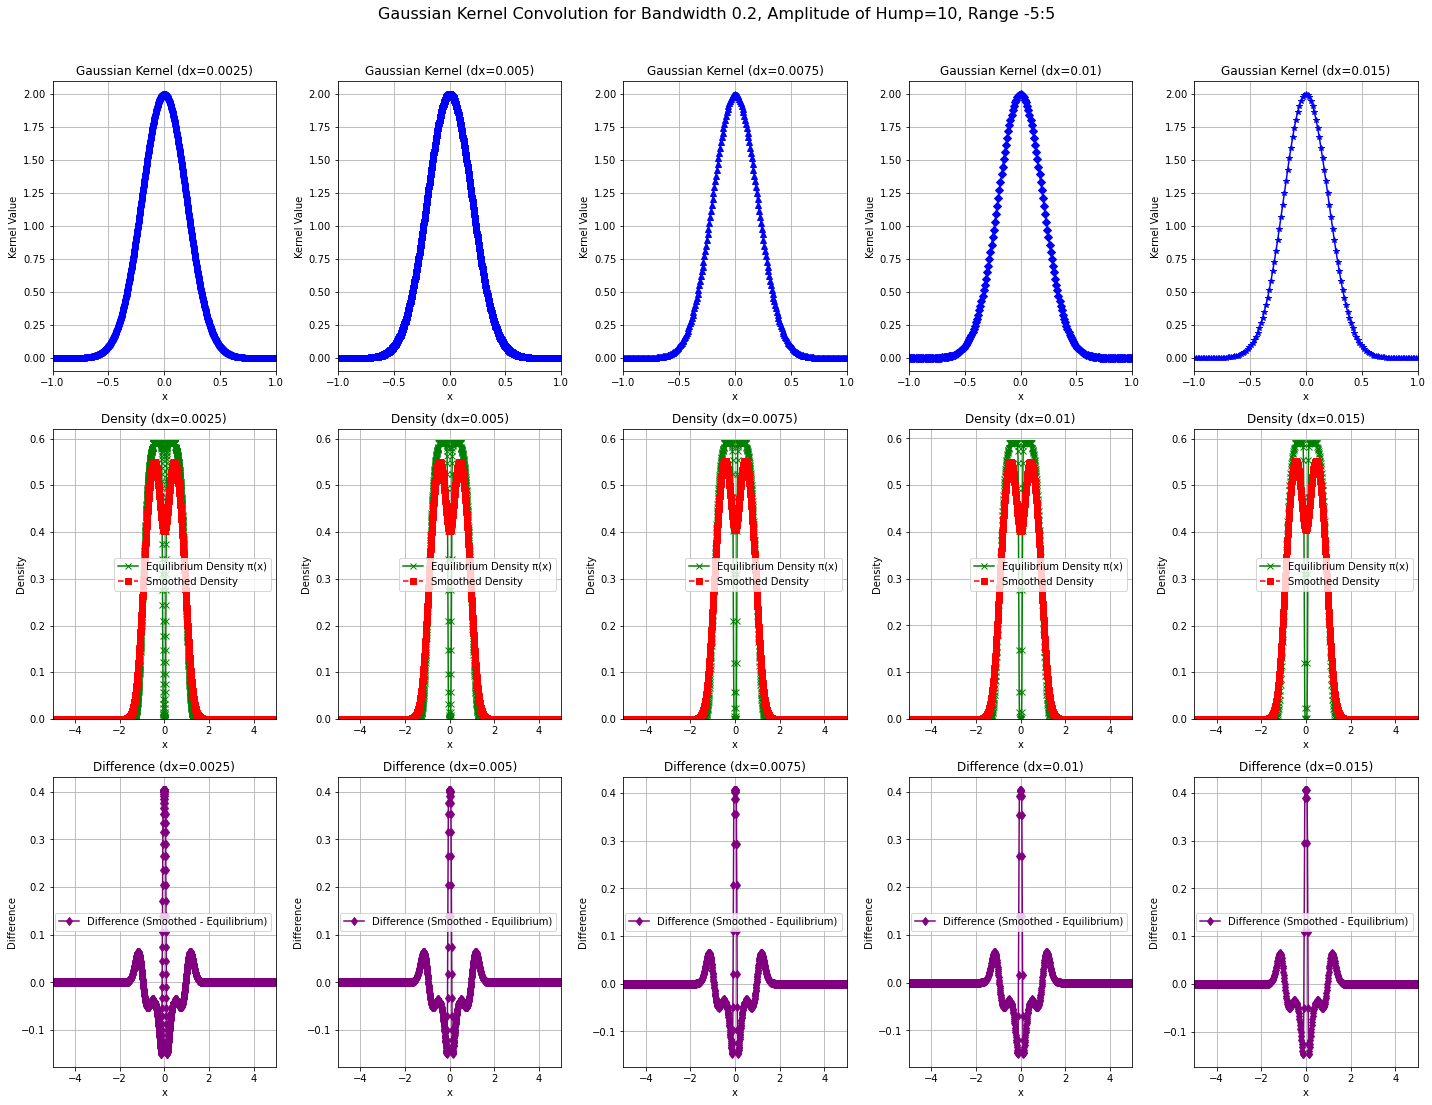

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# New Potential Function V(x)
def V(x, sigma_pot=0.05, y0=0.1, A=10.0, a=1.0, x_c=0.5):
    """
    Computes the 1D potential function mimicking the 2D entropic double-well potential.

    Parameters:
    - x: The position at which to evaluate the potential.
    - sigma_pot: The width of the barrier, controls the sharpness of the hump.
    - y0: The y-parameter of the original 2D potential, kept constant here.
    - A: Amplitude of the middle hump.
    - a: Scaling factor for the potential.
    - x_c: Critical value where the function transitions from inside to outside the barrier.

    Returns:
    - V(x): The potential value at position x.
    """
    if np.abs(x) > x_c:
        # Outside the barrier region; the potential grows like x^6
        return a * x**6
    else:
        # Inside the barrier region; use a Gaussian-like function to create the middle hump
        return A * np.exp(-(x/sigma_pot)**2) * (1 - np.exp(-(y0/sigma_pot)**2))

def gaussian_kernel(x, sigma_kernel):
    """Gaussian Kernel function."""
    coeff = 1.0 / (np.sqrt(2.0 * np.pi) * sigma_kernel)
    exponent = -0.5 * (x**2) / (sigma_kernel**2)
    return coeff * np.exp(exponent)

def convolve_density(boltz_array, kernel_array, dx):
    """Perform convolution on the density array."""
    npoints_pot = len(boltz_array)
    npoints_kernel = len(kernel_array)
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half = (npoints_kernel - 1) // 2
    
    for kount in range(npoints_pot):
        for kount_kernel in range(npoints_kernel):
            kount_kernel_shifted = kount - kernel_half + kount_kernel
            if 0 <= kount_kernel_shifted < npoints_pot:
                boltz_array_conv[kount_kernel_shifted] += boltz_array[kount] * kernel_array[kount_kernel] * dx
    
    return boltz_array_conv

def plot_results(lattice_spacings, sigma_kernel, x_min, x_max):
    fig, axs = plt.subplots(3, len(lattice_spacings), figsize=(20, 15))
    
    # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    markers = ['o', 's', '^', 'D', '*']  # Different markers for different plots
    colors = ['orange', 'green', 'red', 'purple', 'blue']  # Different colors for different plots

    for i, dx in enumerate(lattice_spacings):
        npoints_pot = int((x_max - x_min - 0.1 * dx) / dx) + 2
        x = np.linspace(x_min, x_max, npoints_pot)

        potential_array = np.array([V(xi) for xi in x])
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density using the trapezium rule
        boltz_array /= np.trapz(boltz_array, x)
        
        # Kernel and its convolution
        # Extend Kernel to cover 5*sigma_kernel
        kernel_size = int(5 * sigma_kernel)  # Extending kernel size
        npoints_kernel = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel = 2 * npoints_kernel + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel)
        kernel_array = np.array([gaussian_kernel(kx, sigma_kernel) for kx in kernel_x])
        
        # Normalize the kernel using the trapezium rule
        kernel_integral = np.trapz(kernel_array, kernel_x)
        kernel_array /= kernel_integral
        
        # Print the integral of the kernel to check if it is equal to one
        print(f'Integral of the Gaussian kernel for dx={dx}: {np.trapz(kernel_array, kernel_x)}')
        
        boltz_array_conv = convolve_density(boltz_array, kernel_array, dx)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Gaussian Kernel
        axs[0, i].plot(kernel_x, kernel_array, color='blue', marker=markers[i % len(markers)])
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('Kernel Value')
        axs[0, i].set_title(f'Gaussian Kernel (dx={dx})')
        axs[0, i].grid(True)
        axs[0, i].set_xlim(-kernel_size, kernel_size)  # Updated to 5*sigma_kernel
        
        # Plot Equilibrium Density and Smoothed Density
        axs[1, i].plot(x, boltz_array, label='Equilibrium Density π(x)', color='green', marker='x')
        axs[1, i].plot(x, boltz_array_conv, label='Smoothed Density', color='red', linestyle='--', marker='s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Density')
        axs[1, i].set_title(f'Density (dx={dx})')
        axs[1, i].legend()
        axs[1, i].grid(True)
        axs[1, i].set_xlim(x_min, x_max)
        axs[1, i].set_ylim(bottom=0)  # Ensure densities start from zero
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[2, i].plot(x, density_difference, label='Difference (Smoothed - Equilibrium)', color='purple', marker='d')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('Difference')
        axs[2, i].set_title(f'Difference (dx={dx})')
        axs[2, i].legend()
        axs[2, i].grid(True)
        axs[2, i].set_xlim(x_min, x_max)
        
    # Add a main title to the figure
    fig.suptitle('Gaussian Kernel Convolution for Bandwidth 0.2, Amplitude of Hump=10, Range -5:5', fontsize=16, y=1.02)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig('GK_1d2d_a10_bwo2.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.0025, 0.005, 0.0075, 0.01, 0.015]  # Finer lattice spacings
    sigma_kernel = 0.2  # Fixed bandwidth for Gaussian kernel
    x_min, x_max = -5, 5  # Keeping the x range as -5 to 5
    plot_results(lattice_spacings, sigma_kernel, x_min, x_max)


Integral of the Gaussian kernel for dx=0.0025: 0.9999999999999999
Integral of the Gaussian kernel for dx=0.005: 1.0
Integral of the Gaussian kernel for dx=0.0075: 1.0
Integral of the Gaussian kernel for dx=0.01: 1.0
Integral of the Gaussian kernel for dx=0.015: 1.0


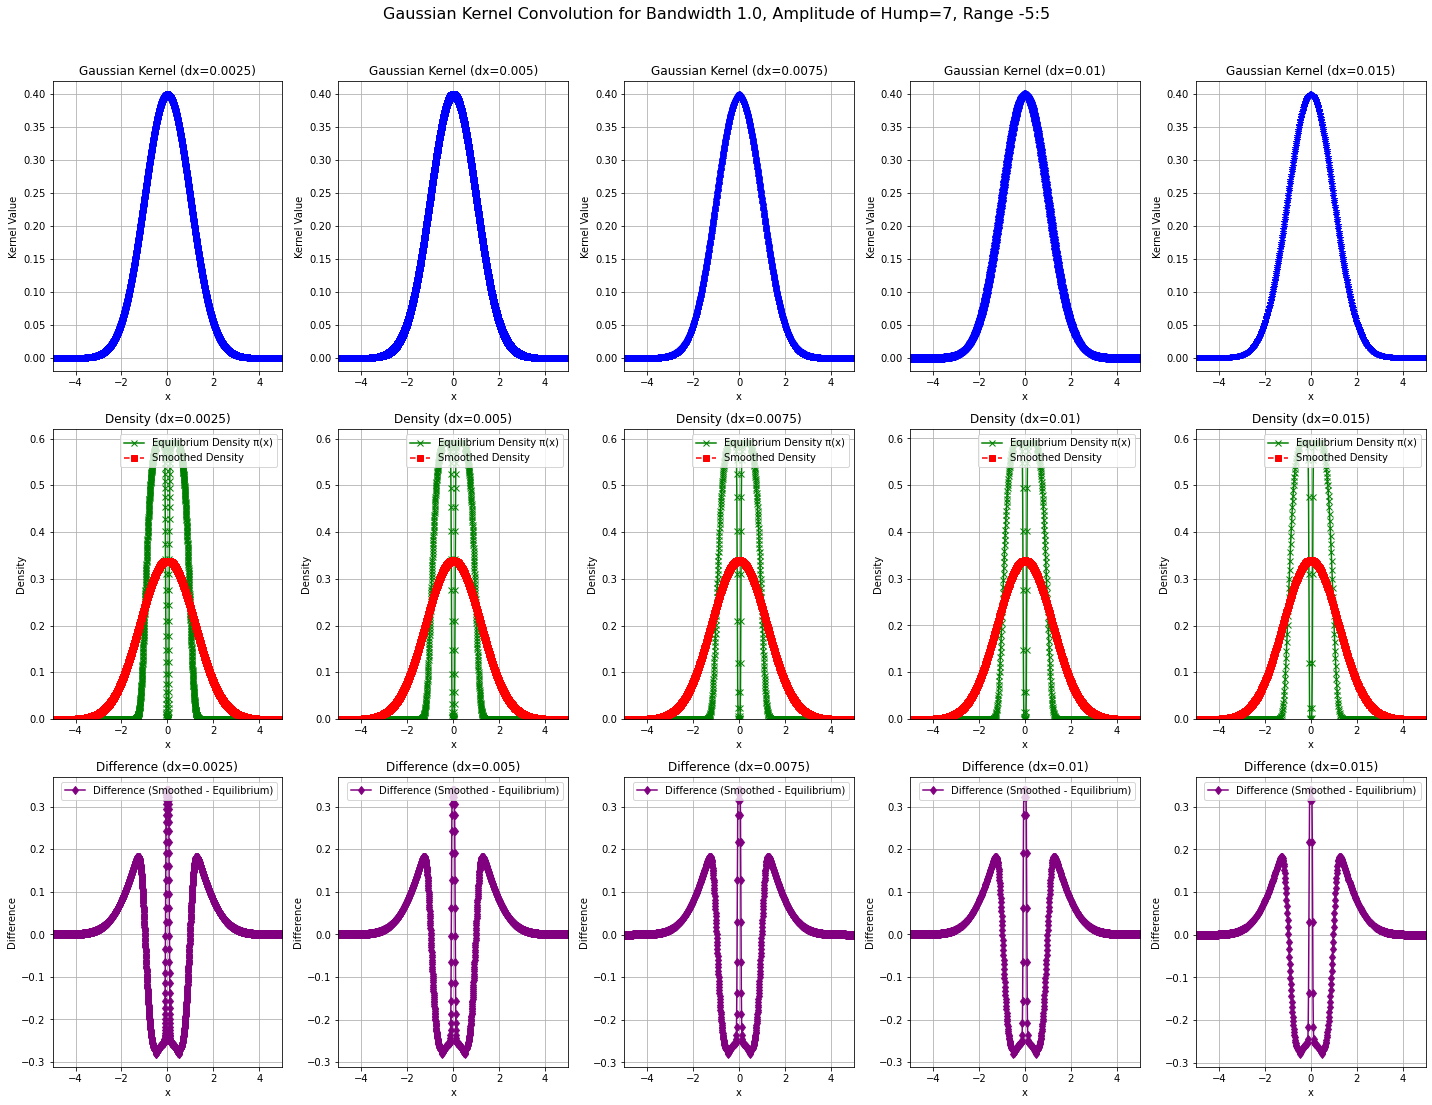

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# New Potential Function V(x)
def V(x, sigma_pot=0.05, y0=0.1, A=10.0, a=1.0, x_c=0.5):
    """
    Computes the 1D potential function mimicking the 2D entropic double-well potential.

    Parameters:
    - x: The position at which to evaluate the potential.
    - sigma_pot: The width of the barrier, controls the sharpness of the hump.
    - y0: The y-parameter of the original 2D potential, kept constant here.
    - A: Amplitude of the middle hump.
    - a: Scaling factor for the potential.
    - x_c: Critical value where the function transitions from inside to outside the barrier.

    Returns:
    - V(x): The potential value at position x.
    """
    if np.abs(x) > x_c:
        # Outside the barrier region; the potential grows like x^6
        return a * x**6
    else:
        # Inside the barrier region; use a Gaussian-like function to create the middle hump
        return A * np.exp(-(x/sigma_pot)**2) * (1 - np.exp(-(y0/sigma_pot)**2))

def gaussian_kernel(x, sigma_kernel):
    """Gaussian Kernel function."""
    coeff = 1.0 / (np.sqrt(2.0 * np.pi) * sigma_kernel)
    exponent = -0.5 * (x**2) / (sigma_kernel**2)
    return coeff * np.exp(exponent)

def convolve_density(boltz_array, kernel_array, dx):
    """Perform convolution on the density array."""
    npoints_pot = len(boltz_array)
    npoints_kernel = len(kernel_array)
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half = (npoints_kernel - 1) // 2
    
    for kount in range(npoints_pot):
        for kount_kernel in range(npoints_kernel):
            kount_kernel_shifted = kount - kernel_half + kount_kernel
            if 0 <= kount_kernel_shifted < npoints_pot:
                boltz_array_conv[kount_kernel_shifted] += boltz_array[kount] * kernel_array[kount_kernel] * dx
    
    return boltz_array_conv

def plot_results(lattice_spacings, sigma_kernel, x_min, x_max):
    fig, axs = plt.subplots(3, len(lattice_spacings), figsize=(20, 15))
    
    # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    markers = ['o', 's', '^', 'D', '*']  # Different markers for different plots
    colors = ['orange', 'green', 'red', 'purple', 'blue']  # Different colors for different plots

    for i, dx in enumerate(lattice_spacings):
        npoints_pot = int((x_max - x_min - 0.1 * dx) / dx) + 2
        x = np.linspace(x_min, x_max, npoints_pot)

        potential_array = np.array([V(xi) for xi in x])
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density using the trapezium rule
        boltz_array /= np.trapz(boltz_array, x)
        
        # Kernel and its convolution
        # Extend Kernel to cover 5*sigma_kernel
        kernel_size = int(5 * sigma_kernel)  # Extending kernel size
        npoints_kernel = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel = 2 * npoints_kernel + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel)
        kernel_array = np.array([gaussian_kernel(kx, sigma_kernel) for kx in kernel_x])
        
        # Normalize the kernel using the trapezium rule
        kernel_integral = np.trapz(kernel_array, kernel_x)
        kernel_array /= kernel_integral
        
        # Print the integral of the kernel to check if it is equal to one
        print(f'Integral of the Gaussian kernel for dx={dx}: {np.trapz(kernel_array, kernel_x)}')
        
        boltz_array_conv = convolve_density(boltz_array, kernel_array, dx)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Gaussian Kernel
        axs[0, i].plot(kernel_x, kernel_array, color='blue', marker=markers[i % len(markers)])
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('Kernel Value')
        axs[0, i].set_title(f'Gaussian Kernel (dx={dx})')
        axs[0, i].grid(True)
        axs[0, i].set_xlim(-kernel_size, kernel_size)  # Updated to 5*sigma_kernel
        
        # Plot Equilibrium Density and Smoothed Density
        axs[1, i].plot(x, boltz_array, label='Equilibrium Density π(x)', color='green', marker='x')
        axs[1, i].plot(x, boltz_array_conv, label='Smoothed Density', color='red', linestyle='--', marker='s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Density')
        axs[1, i].set_title(f'Density (dx={dx})')
        axs[1, i].legend()
        axs[1, i].grid(True)
        axs[1, i].set_xlim(x_min, x_max)
        axs[1, i].set_ylim(bottom=0)  # Ensure densities start from zero
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[2, i].plot(x, density_difference, label='Difference (Smoothed - Equilibrium)', color='purple', marker='d')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('Difference')
        axs[2, i].set_title(f'Difference (dx={dx})')
        axs[2, i].legend()
        axs[2, i].grid(True)
        axs[2, i].set_xlim(x_min, x_max)
        
    # Add a main title to the figure
    fig.suptitle('Gaussian Kernel Convolution for Bandwidth 1.0, Amplitude of Hump=7, Range -5:5', fontsize=16, y=1.02)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig('GK_1d2d_a7_bw1.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.0025, 0.005, 0.0075, 0.01, 0.015]  # Finer lattice spacings
    sigma_kernel = 1.0  # Fixed bandwidth for Gaussian kernel
    x_min, x_max = -5, 5  # Keeping the x range as -5 to 5
    plot_results(lattice_spacings, sigma_kernel, x_min, x_max)


Integral of the Gaussian kernel for dx=0.0025: 0.9999999999999999
Integral of the Gaussian kernel for dx=0.005: 1.0
Integral of the Gaussian kernel for dx=0.0075: 1.0
Integral of the Gaussian kernel for dx=0.01: 1.0
Integral of the Gaussian kernel for dx=0.015: 1.0


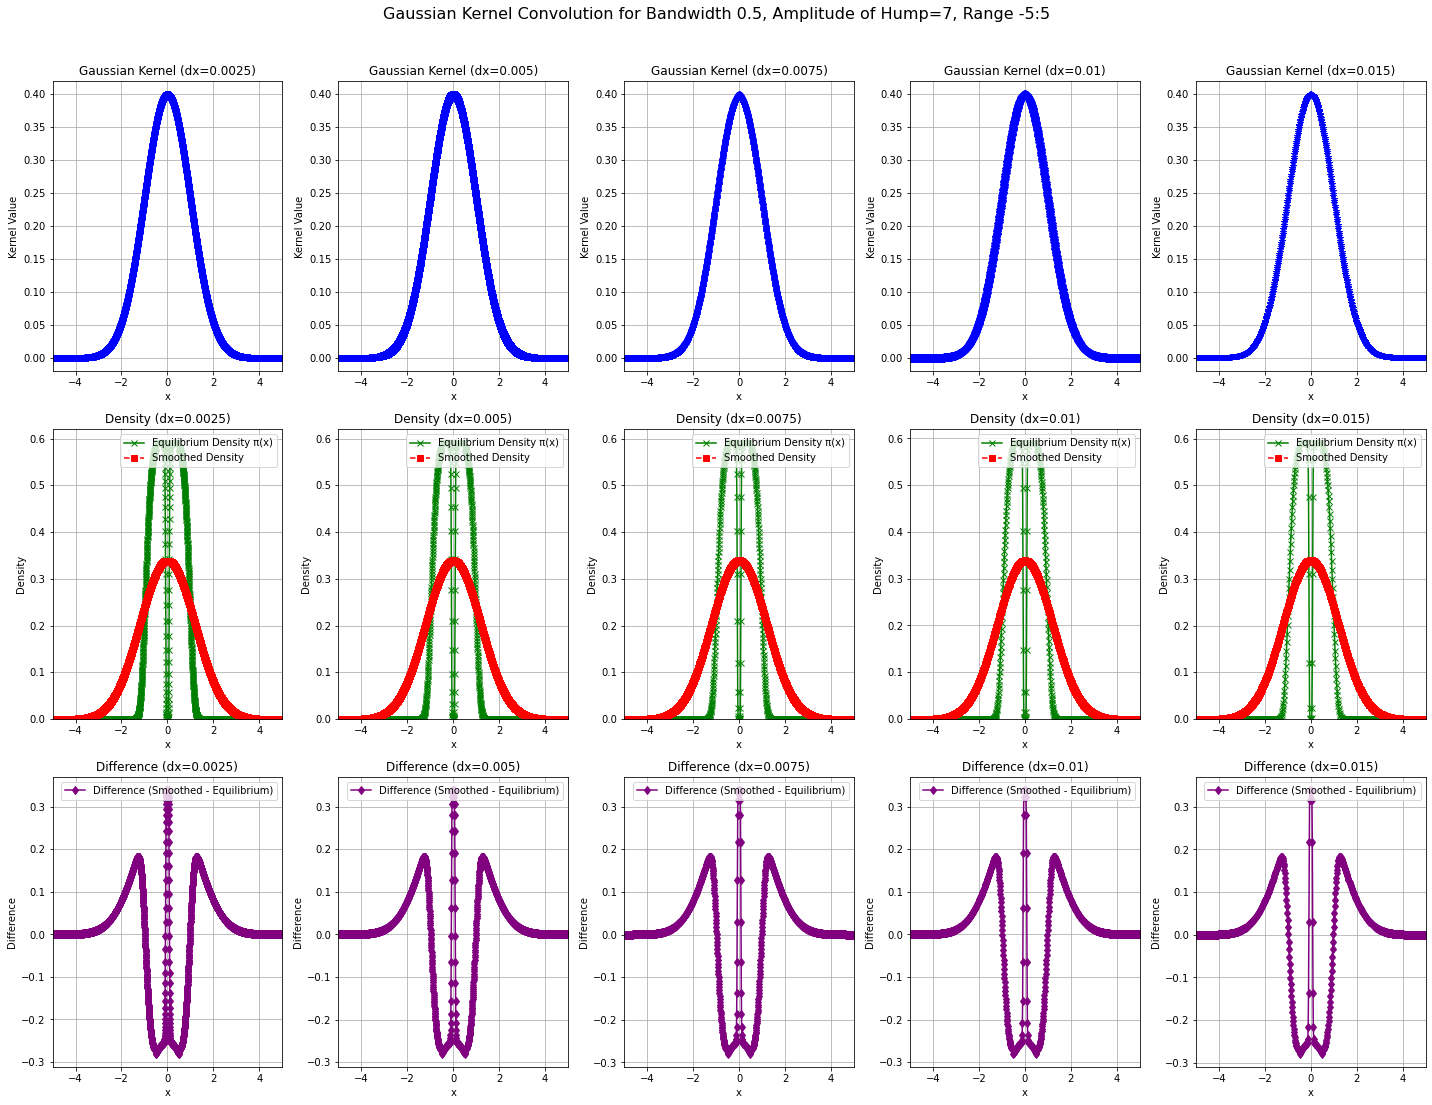

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# New Potential Function V(x)
def V(x, sigma_pot=0.05, y0=0.1, A=10.0, a=1.0, x_c=0.5):
    """
    Computes the 1D potential function mimicking the 2D entropic double-well potential.

    Parameters:
    - x: The position at which to evaluate the potential.
    - sigma_pot: The width of the barrier, controls the sharpness of the hump.
    - y0: The y-parameter of the original 2D potential, kept constant here.
    - A: Amplitude of the middle hump.
    - a: Scaling factor for the potential.
    - x_c: Critical value where the function transitions from inside to outside the barrier.

    Returns:
    - V(x): The potential value at position x.
    """
    if np.abs(x) > x_c:
        # Outside the barrier region; the potential grows like x^6
        return a * x**6
    else:
        # Inside the barrier region; use a Gaussian-like function to create the middle hump
        return A * np.exp(-(x/sigma_pot)**2) * (1 - np.exp(-(y0/sigma_pot)**2))

def gaussian_kernel(x, sigma_kernel):
    """Gaussian Kernel function."""
    coeff = 1.0 / (np.sqrt(2.0 * np.pi) * sigma_kernel)
    exponent = -0.5 * (x**2) / (sigma_kernel**2)
    return coeff * np.exp(exponent)

def convolve_density(boltz_array, kernel_array, dx):
    """Perform convolution on the density array."""
    npoints_pot = len(boltz_array)
    npoints_kernel = len(kernel_array)
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half = (npoints_kernel - 1) // 2
    
    for kount in range(npoints_pot):
        for kount_kernel in range(npoints_kernel):
            kount_kernel_shifted = kount - kernel_half + kount_kernel
            if 0 <= kount_kernel_shifted < npoints_pot:
                boltz_array_conv[kount_kernel_shifted] += boltz_array[kount] * kernel_array[kount_kernel] * dx
    
    return boltz_array_conv

def plot_results(lattice_spacings, sigma_kernel, x_min, x_max):
    fig, axs = plt.subplots(3, len(lattice_spacings), figsize=(20, 15))
    
    # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    markers = ['o', 's', '^', 'D', '*']  # Different markers for different plots
    colors = ['orange', 'green', 'red', 'purple', 'blue']  # Different colors for different plots

    for i, dx in enumerate(lattice_spacings):
        npoints_pot = int((x_max - x_min - 0.1 * dx) / dx) + 2
        x = np.linspace(x_min, x_max, npoints_pot)

        potential_array = np.array([V(xi) for xi in x])
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density using the trapezium rule
        boltz_array /= np.trapz(boltz_array, x)
        
        # Kernel and its convolution
        # Extend Kernel to cover 5*sigma_kernel
        kernel_size = int(5 * sigma_kernel)  # Extending kernel size
        npoints_kernel = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel = 2 * npoints_kernel + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel)
        kernel_array = np.array([gaussian_kernel(kx, sigma_kernel) for kx in kernel_x])
        
        # Normalize the kernel using the trapezium rule
        kernel_integral = np.trapz(kernel_array, kernel_x)
        kernel_array /= kernel_integral
        
        # Print the integral of the kernel to check if it is equal to one
        print(f'Integral of the Gaussian kernel for dx={dx}: {np.trapz(kernel_array, kernel_x)}')
        
        boltz_array_conv = convolve_density(boltz_array, kernel_array, dx)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Gaussian Kernel
        axs[0, i].plot(kernel_x, kernel_array, color='blue', marker=markers[i % len(markers)])
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('Kernel Value')
        axs[0, i].set_title(f'Gaussian Kernel (dx={dx})')
        axs[0, i].grid(True)
        axs[0, i].set_xlim(-kernel_size, kernel_size)  # Updated to 5*sigma_kernel
        
        # Plot Equilibrium Density and Smoothed Density
        axs[1, i].plot(x, boltz_array, label='Equilibrium Density π(x)', color='green', marker='x')
        axs[1, i].plot(x, boltz_array_conv, label='Smoothed Density', color='red', linestyle='--', marker='s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Density')
        axs[1, i].set_title(f'Density (dx={dx})')
        axs[1, i].legend()
        axs[1, i].grid(True)
        axs[1, i].set_xlim(x_min, x_max)
        axs[1, i].set_ylim(bottom=0)  # Ensure densities start from zero
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[2, i].plot(x, density_difference, label='Difference (Smoothed - Equilibrium)', color='purple', marker='d')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('Difference')
        axs[2, i].set_title(f'Difference (dx={dx})')
        axs[2, i].legend()
        axs[2, i].grid(True)
        axs[2, i].set_xlim(x_min, x_max)
        
    # Add a main title to the figure
    fig.suptitle('Gaussian Kernel Convolution for Bandwidth 0.5, Amplitude of Hump=7, Range -5:5', fontsize=16, y=1.02)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig('GK_1d2d_a7_bwo5.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.0025, 0.005, 0.0075, 0.01, 0.015]  # Finer lattice spacings
    sigma_kernel = 1.0  # Fixed bandwidth for Gaussian kernel
    x_min, x_max = -5, 5  # Keeping the x range as -5 to 5
    plot_results(lattice_spacings, sigma_kernel, x_min, x_max)


Integral of the Piecewise Parabolic Kernel for dx=0.0025: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.005: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.0075: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.01: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.015: 0.9999999999999999


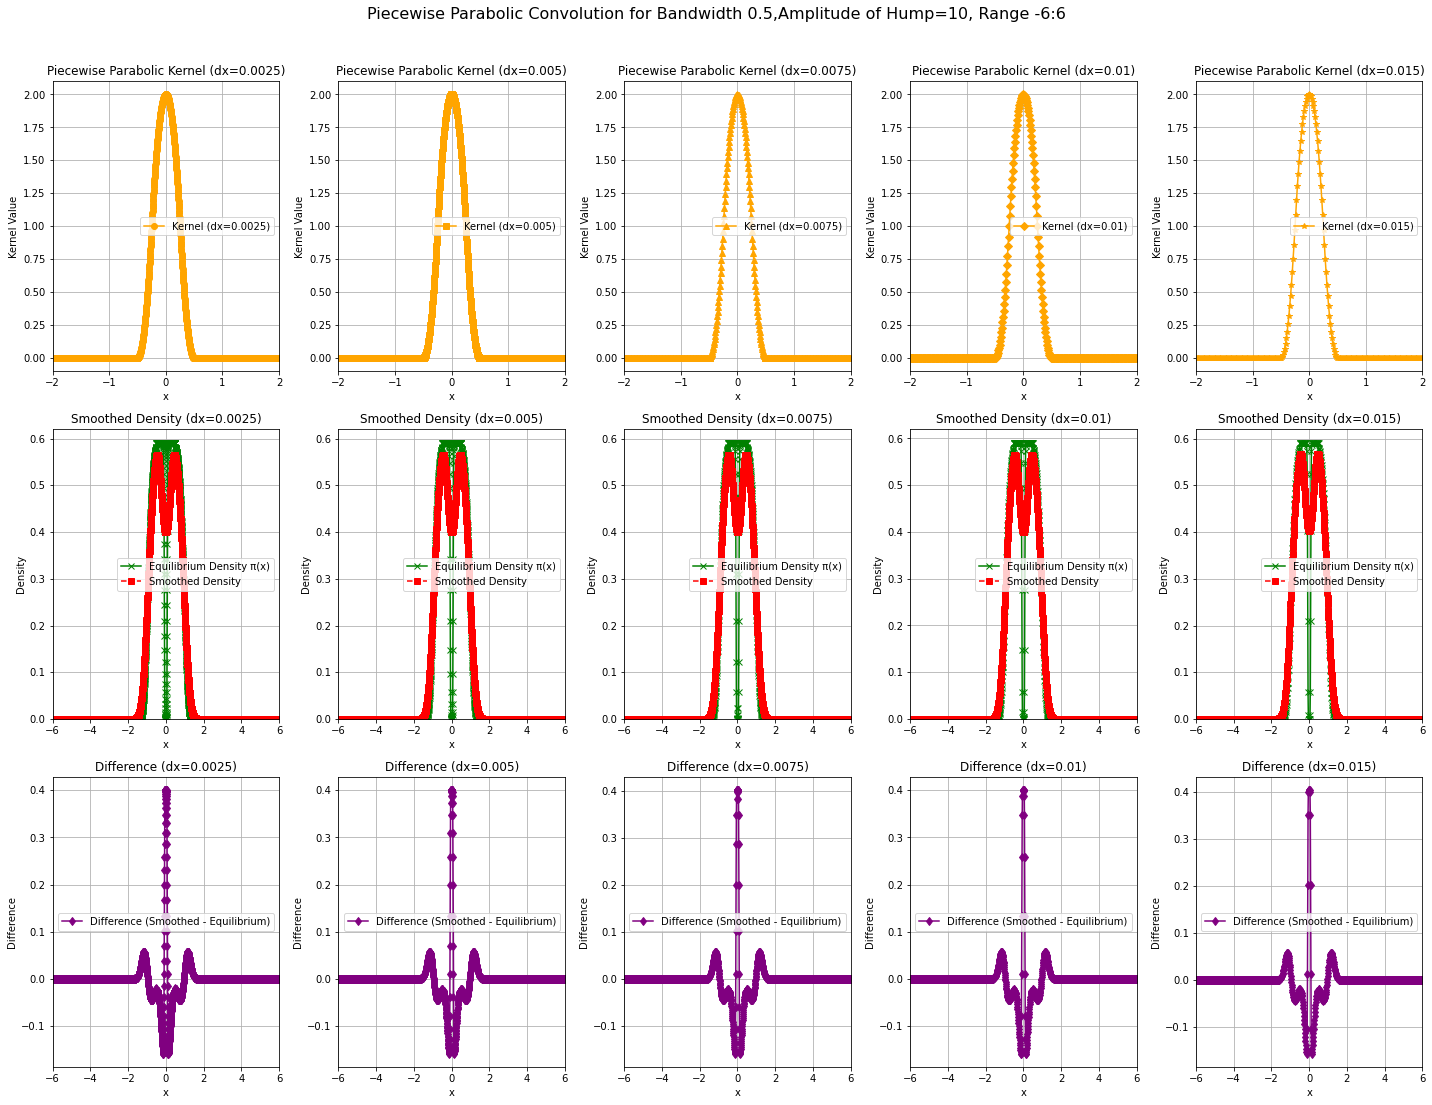

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# New 1D Potential Function with a reduced middle hump
def V(x, sigma_pot=0.05, y0=0.1, A=10.0, a=1.0, x_c=0.5):
    """
    Computes the 1D potential function mimicking the 2D entropic double-well potential.

    Parameters:
    - x: The position at which to evaluate the potential.
    - sigma_pot: The width of the barrier, controls the sharpness of the hump.
    - y0: The y-parameter of the original 2D potential, kept constant here.
    - A: Amplitude of the middle hump.
    - a: Scaling factor for the potential.
    - x_c: Critical value where the function transitions from inside to outside the barrier.

    Returns:
    - V(x): The potential value at position x.
    """
    if np.abs(x) > x_c:
        # Outside the barrier region; the potential grows like x^6
        return a * x**6
    else:
        # Inside the barrier region; use a Gaussian-like function to create the middle hump
        return A * np.exp(-(x/sigma_pot)**2) * (1 - np.exp(-(y0/sigma_pot)**2))

def piecewise_parabolic_kernel(x, sigma_kernel):
    """Piecewise Parabolic Kernel function."""
    if x <= -sigma_kernel or x >= sigma_kernel:
        return 0.0
    elif x <= -0.5 * sigma_kernel:
        kernel_value = 1.0 + x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 2.0 * kernel_value / sigma_kernel
    elif x >= 0.5 * sigma_kernel:
        kernel_value = 1.0 - x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 2.0 * kernel_value / sigma_kernel
    else:
        kernel_value = x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 1.0 - 2.0 * kernel_value
        kernel_value = kernel_value / sigma_kernel
    return kernel_value

def convolve_density(boltz_array, kernel_array, dx):
    """Perform convolution on the density array."""
    npoints_pot = len(boltz_array)
    npoints_kernel = len(kernel_array)
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half = (npoints_kernel - 1) // 2
    
    for kount in range(npoints_pot):
        for kount_kernel in range(npoints_kernel):
            kount_kernel_shifted = kount - kernel_half + kount_kernel
            if 0 <= kount_kernel_shifted < npoints_pot:
                boltz_array_conv[kount_kernel_shifted] += boltz_array[kount] * kernel_array[kount_kernel] * dx
    
    return boltz_array_conv

def plot_results(lattice_spacings, sigma_kernel, x_min, x_max):
    fig, axs = plt.subplots(3, len(lattice_spacings), figsize=(20, 15))
    
    # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    markers = ['o', 's', '^', 'D', '*']  # Different markers for different plots
    colors = ['orange', 'green', 'red', 'purple']  # Different colors for different plots

    for i, dx in enumerate(lattice_spacings):
        npoints_pot = int((x_max - x_min - 0.1 * dx) / dx) + 2
        x = np.linspace(x_min, x_max, npoints_pot)

        potential_array = np.array([V(xi) for xi in x])
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density using the trapezium rule
        boltz_array /= np.trapz(boltz_array, x)
        
        # Kernel and its convolution
        # Extend Kernel to cover 5*sigma_kernel
        kernel_size = int(5 * sigma_kernel)  # Extending kernel size
        npoints_kernel = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel = 2 * npoints_kernel + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel)
        kernel_array = np.array([piecewise_parabolic_kernel(kx, sigma_kernel) for kx in kernel_x])
        
        # Normalize the kernel using the trapezium rule
        kernel_array /= np.trapz(kernel_array, kernel_x)
        
        # Print out the integral of the kernel to check it sums to one
        kernel_integral = np.trapz(kernel_array, kernel_x)
        print(f"Integral of the Piecewise Parabolic Kernel for dx={dx}: {kernel_integral}")
        
        boltz_array_conv = convolve_density(boltz_array, kernel_array, dx)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Piecewise Parabolic Kernel
        axs[0, i].plot(kernel_x, kernel_array, label=f'Kernel (dx={dx})', color='orange', marker=markers[i % len(markers)])
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('Kernel Value')
        axs[0, i].set_title(f'Piecewise Parabolic Kernel (dx={dx})')
        axs[0, i].legend()
        axs[0, i].grid(True)
        axs[0, i].set_xlim(-kernel_size, kernel_size)
        
        # Plot Equilibrium Density and Smoothed Density
        axs[1, i].plot(x, boltz_array, label='Equilibrium Density π(x)', color='green', marker='x')
        axs[1, i].plot(x, boltz_array_conv, label='Smoothed Density', color='red', linestyle='--', marker='s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Density')
        axs[1, i].set_title(f'Smoothed Density (dx={dx})')
        axs[1, i].legend()
        axs[1, i].grid(True)
        axs[1, i].set_xlim(x_min, x_max)
        axs[1, i].set_ylim(bottom=0)  # Ensure densities start from zero
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[2, i].plot(x, density_difference, label='Difference (Smoothed - Equilibrium)', color='purple', marker='d')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('Difference')
        axs[2, i].set_title(f'Difference (dx={dx})')
        axs[2, i].legend()
        axs[2, i].grid(True)
        axs[2, i].set_xlim(x_min, x_max)

    # Add a main title to the figure
    fig.suptitle('Piecewise Parabolic Convolution for Bandwidth 0.5,Amplitude of Hump=10, Range -6:6', fontsize=16, y=1.02)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig('PPD_1d_2d_bwo5_a10.png', dpi=300, bbox_inches='tight', facecolor='white')  # Ensure white background
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.0025, 0.005, 0.0075, 0.01, 0.015]  # Finer lattice spacings
    sigma_kernel = 0.5  # Fixed bandwidth for the kernel
    x_min, x_max = -6, 6  # Extend range to cover more of the density tail
    plot_results(lattice_spacings, sigma_kernel, x_min, x_max)


Integral of the Piecewise Parabolic Kernel for dx=0.0025: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.005: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.0075: 0.9999999999999999
Integral of the Piecewise Parabolic Kernel for dx=0.01: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.015: 1.0


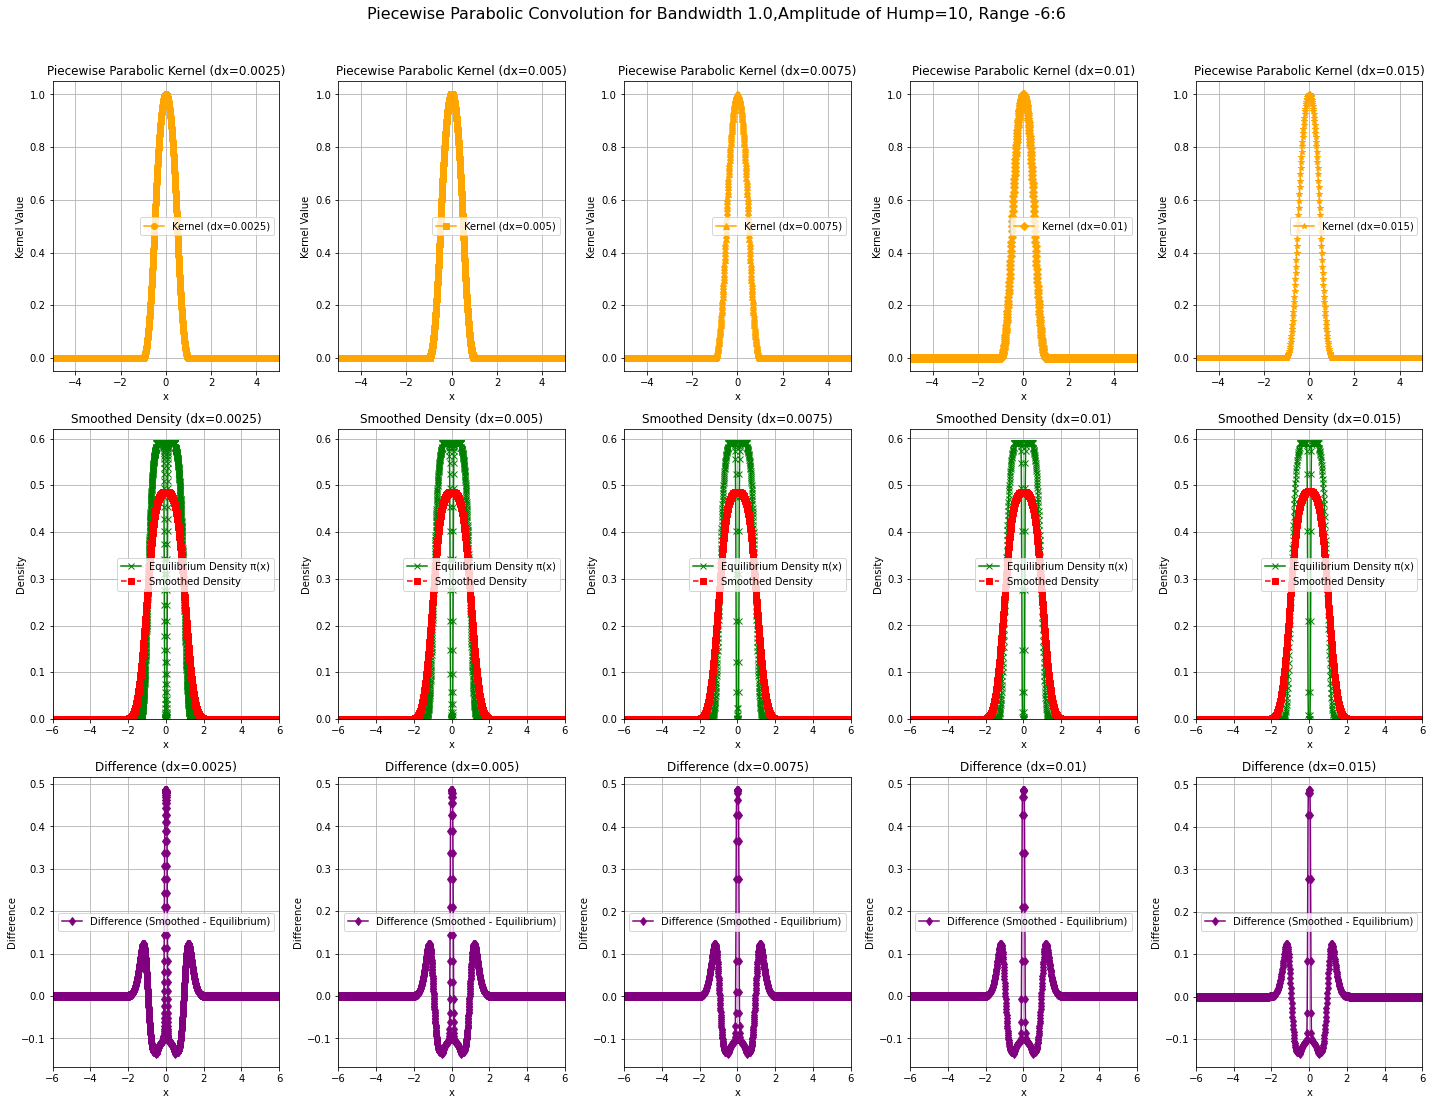

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# New 1D Potential Function with a reduced middle hump
def V(x, sigma_pot=0.05, y0=0.1, A=10.0, a=1.0, x_c=0.5):
    """
    Computes the 1D potential function mimicking the 2D entropic double-well potential.

    Parameters:
    - x: The position at which to evaluate the potential.
    - sigma_pot: The width of the barrier, controls the sharpness of the hump.
    - y0: The y-parameter of the original 2D potential, kept constant here.
    - A: Amplitude of the middle hump.
    - a: Scaling factor for the potential.
    - x_c: Critical value where the function transitions from inside to outside the barrier.

    Returns:
    - V(x): The potential value at position x.
    """
    if np.abs(x) > x_c:
        # Outside the barrier region; the potential grows like x^6
        return a * x**6
    else:
        # Inside the barrier region; use a Gaussian-like function to create the middle hump
        return A * np.exp(-(x/sigma_pot)**2) * (1 - np.exp(-(y0/sigma_pot)**2))

def piecewise_parabolic_kernel(x, sigma_kernel):
    """Piecewise Parabolic Kernel function."""
    if x <= -sigma_kernel or x >= sigma_kernel:
        return 0.0
    elif x <= -0.5 * sigma_kernel:
        kernel_value = 1.0 + x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 2.0 * kernel_value / sigma_kernel
    elif x >= 0.5 * sigma_kernel:
        kernel_value = 1.0 - x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 2.0 * kernel_value / sigma_kernel
    else:
        kernel_value = x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 1.0 - 2.0 * kernel_value
        kernel_value = kernel_value / sigma_kernel
    return kernel_value

def convolve_density(boltz_array, kernel_array, dx):
    """Perform convolution on the density array."""
    npoints_pot = len(boltz_array)
    npoints_kernel = len(kernel_array)
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half = (npoints_kernel - 1) // 2
    
    for kount in range(npoints_pot):
        for kount_kernel in range(npoints_kernel):
            kount_kernel_shifted = kount - kernel_half + kount_kernel
            if 0 <= kount_kernel_shifted < npoints_pot:
                boltz_array_conv[kount_kernel_shifted] += boltz_array[kount] * kernel_array[kount_kernel] * dx
    
    return boltz_array_conv

def plot_results(lattice_spacings, sigma_kernel, x_min, x_max):
    fig, axs = plt.subplots(3, len(lattice_spacings), figsize=(20, 15))
    
    # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    markers = ['o', 's', '^', 'D', '*']  # Different markers for different plots
    colors = ['orange', 'green', 'red', 'purple']  # Different colors for different plots

    for i, dx in enumerate(lattice_spacings):
        npoints_pot = int((x_max - x_min - 0.1 * dx) / dx) + 2
        x = np.linspace(x_min, x_max, npoints_pot)

        potential_array = np.array([V(xi) for xi in x])
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density using the trapezium rule
        boltz_array /= np.trapz(boltz_array, x)
        
        # Kernel and its convolution
        # Extend Kernel to cover 5*sigma_kernel
        kernel_size = int(5 * sigma_kernel)  # Extending kernel size
        npoints_kernel = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel = 2 * npoints_kernel + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel)
        kernel_array = np.array([piecewise_parabolic_kernel(kx, sigma_kernel) for kx in kernel_x])
        
        # Normalize the kernel using the trapezium rule
        kernel_array /= np.trapz(kernel_array, kernel_x)
        
        # Print out the integral of the kernel to check it sums to one
        kernel_integral = np.trapz(kernel_array, kernel_x)
        print(f"Integral of the Piecewise Parabolic Kernel for dx={dx}: {kernel_integral}")
        
        boltz_array_conv = convolve_density(boltz_array, kernel_array, dx)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Piecewise Parabolic Kernel
        axs[0, i].plot(kernel_x, kernel_array, label=f'Kernel (dx={dx})', color='orange', marker=markers[i % len(markers)])
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('Kernel Value')
        axs[0, i].set_title(f'Piecewise Parabolic Kernel (dx={dx})')
        axs[0, i].legend()
        axs[0, i].grid(True)
        axs[0, i].set_xlim(-kernel_size, kernel_size)
        
        # Plot Equilibrium Density and Smoothed Density
        axs[1, i].plot(x, boltz_array, label='Equilibrium Density π(x)', color='green', marker='x')
        axs[1, i].plot(x, boltz_array_conv, label='Smoothed Density', color='red', linestyle='--', marker='s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Density')
        axs[1, i].set_title(f'Smoothed Density (dx={dx})')
        axs[1, i].legend()
        axs[1, i].grid(True)
        axs[1, i].set_xlim(x_min, x_max)
        axs[1, i].set_ylim(bottom=0)  # Ensure densities start from zero
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[2, i].plot(x, density_difference, label='Difference (Smoothed - Equilibrium)', color='purple', marker='d')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('Difference')
        axs[2, i].set_title(f'Difference (dx={dx})')
        axs[2, i].legend()
        axs[2, i].grid(True)
        axs[2, i].set_xlim(x_min, x_max)

    # Add a main title to the figure
    fig.suptitle('Piecewise Parabolic Convolution for Bandwidth 1.0,Amplitude of Hump=10, Range -6:6', fontsize=16, y=1.02)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig('PPD_1d_2d_bw1_a10.png', dpi=300, bbox_inches='tight', facecolor='white')  # Ensure white background
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.0025, 0.005, 0.0075, 0.01, 0.015]  # Finer lattice spacings
    sigma_kernel = 1.0  # Fixed bandwidth for the kernel
    x_min, x_max = -6, 6  # Extend range to cover more of the density tail
    plot_results(lattice_spacings, sigma_kernel, x_min, x_max)


Integral of the Piecewise Parabolic Kernel for dx=0.0025: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.005: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.0075: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.01: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.015: 0.9999999999999999


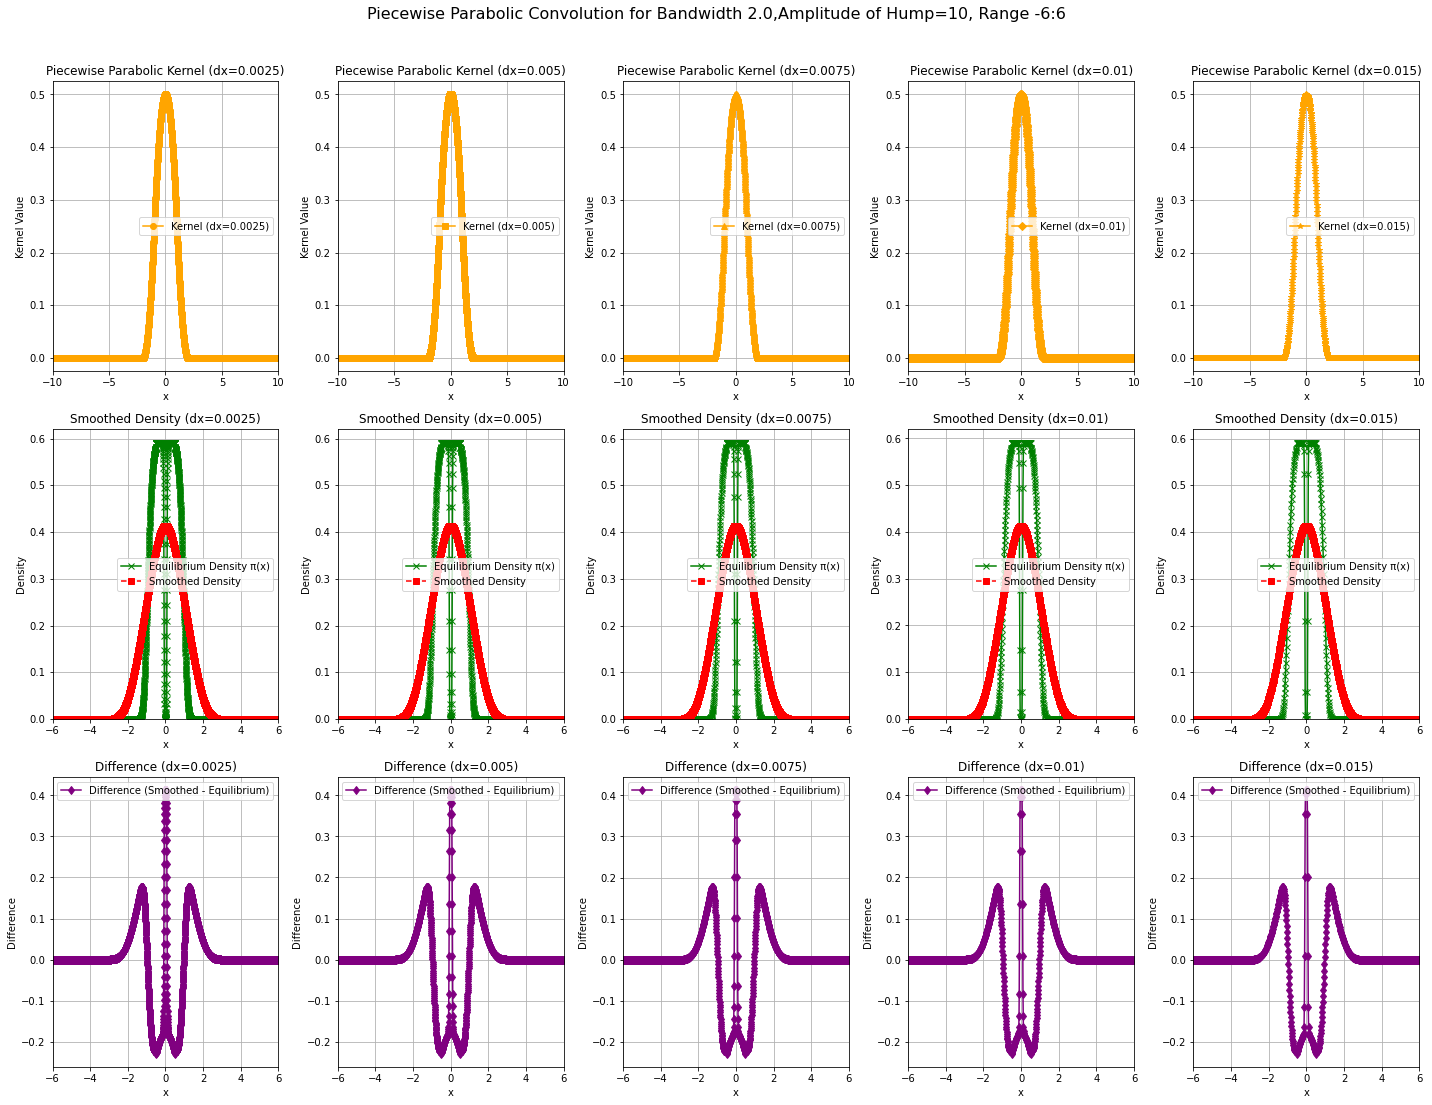

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# New 1D Potential Function with a reduced middle hump
def V(x, sigma_pot=0.05, y0=0.1, A=10.0, a=1.0, x_c=0.5):
    """
    Computes the 1D potential function mimicking the 2D entropic double-well potential.

    Parameters:
    - x: The position at which to evaluate the potential.
    - sigma_pot: The width of the barrier, controls the sharpness of the hump.
    - y0: The y-parameter of the original 2D potential, kept constant here.
    - A: Amplitude of the middle hump.
    - a: Scaling factor for the potential.
    - x_c: Critical value where the function transitions from inside to outside the barrier.

    Returns:
    - V(x): The potential value at position x.
    """
    if np.abs(x) > x_c:
        # Outside the barrier region; the potential grows like x^6
        return a * x**6
    else:
        # Inside the barrier region; use a Gaussian-like function to create the middle hump
        return A * np.exp(-(x/sigma_pot)**2) * (1 - np.exp(-(y0/sigma_pot)**2))

def piecewise_parabolic_kernel(x, sigma_kernel):
    """Piecewise Parabolic Kernel function."""
    if x <= -sigma_kernel or x >= sigma_kernel:
        return 0.0
    elif x <= -0.5 * sigma_kernel:
        kernel_value = 1.0 + x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 2.0 * kernel_value / sigma_kernel
    elif x >= 0.5 * sigma_kernel:
        kernel_value = 1.0 - x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 2.0 * kernel_value / sigma_kernel
    else:
        kernel_value = x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 1.0 - 2.0 * kernel_value
        kernel_value = kernel_value / sigma_kernel
    return kernel_value

def convolve_density(boltz_array, kernel_array, dx):
    """Perform convolution on the density array."""
    npoints_pot = len(boltz_array)
    npoints_kernel = len(kernel_array)
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half = (npoints_kernel - 1) // 2
    
    for kount in range(npoints_pot):
        for kount_kernel in range(npoints_kernel):
            kount_kernel_shifted = kount - kernel_half + kount_kernel
            if 0 <= kount_kernel_shifted < npoints_pot:
                boltz_array_conv[kount_kernel_shifted] += boltz_array[kount] * kernel_array[kount_kernel] * dx
    
    return boltz_array_conv

def plot_results(lattice_spacings, sigma_kernel, x_min, x_max):
    fig, axs = plt.subplots(3, len(lattice_spacings), figsize=(20, 15))
    
    # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    markers = ['o', 's', '^', 'D', '*']  # Different markers for different plots
    colors = ['orange', 'green', 'red', 'purple']  # Different colors for different plots

    for i, dx in enumerate(lattice_spacings):
        npoints_pot = int((x_max - x_min - 0.1 * dx) / dx) + 2
        x = np.linspace(x_min, x_max, npoints_pot)

        potential_array = np.array([V(xi) for xi in x])
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density using the trapezium rule
        boltz_array /= np.trapz(boltz_array, x)
        
        # Kernel and its convolution
        # Extend Kernel to cover 5*sigma_kernel
        kernel_size = int(5 * sigma_kernel)  # Extending kernel size
        npoints_kernel = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel = 2 * npoints_kernel + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel)
        kernel_array = np.array([piecewise_parabolic_kernel(kx, sigma_kernel) for kx in kernel_x])
        
        # Normalize the kernel using the trapezium rule
        kernel_array /= np.trapz(kernel_array, kernel_x)
        
        # Print out the integral of the kernel to check it sums to one
        kernel_integral = np.trapz(kernel_array, kernel_x)
        print(f"Integral of the Piecewise Parabolic Kernel for dx={dx}: {kernel_integral}")
        
        boltz_array_conv = convolve_density(boltz_array, kernel_array, dx)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Piecewise Parabolic Kernel
        axs[0, i].plot(kernel_x, kernel_array, label=f'Kernel (dx={dx})', color='orange', marker=markers[i % len(markers)])
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('Kernel Value')
        axs[0, i].set_title(f'Piecewise Parabolic Kernel (dx={dx})')
        axs[0, i].legend()
        axs[0, i].grid(True)
        axs[0, i].set_xlim(-kernel_size, kernel_size)
        
        # Plot Equilibrium Density and Smoothed Density
        axs[1, i].plot(x, boltz_array, label='Equilibrium Density π(x)', color='green', marker='x')
        axs[1, i].plot(x, boltz_array_conv, label='Smoothed Density', color='red', linestyle='--', marker='s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Density')
        axs[1, i].set_title(f'Smoothed Density (dx={dx})')
        axs[1, i].legend()
        axs[1, i].grid(True)
        axs[1, i].set_xlim(x_min, x_max)
        axs[1, i].set_ylim(bottom=0)  # Ensure densities start from zero
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[2, i].plot(x, density_difference, label='Difference (Smoothed - Equilibrium)', color='purple', marker='d')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('Difference')
        axs[2, i].set_title(f'Difference (dx={dx})')
        axs[2, i].legend()
        axs[2, i].grid(True)
        axs[2, i].set_xlim(x_min, x_max)

    # Add a main title to the figure
    fig.suptitle('Piecewise Parabolic Convolution for Bandwidth 2.0,Amplitude of Hump=10, Range -6:6', fontsize=16, y=1.02)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig('PPD_1d_2d_bw2_a10.png', dpi=300, bbox_inches='tight', facecolor='white')  # Ensure white background
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.0025, 0.005, 0.0075, 0.01, 0.015]  # Finer lattice spacings
    sigma_kernel = 2.0  # Fixed bandwidth for the kernel
    x_min, x_max = -6, 6  # Extend range to cover more of the density tail
    plot_results(lattice_spacings, sigma_kernel, x_min, x_max)


Integral of the Piecewise Parabolic Kernel for dx=0.0025: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.005: 1.0000000000000002
Integral of the Piecewise Parabolic Kernel for dx=0.0075: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.01: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.015: 1.0


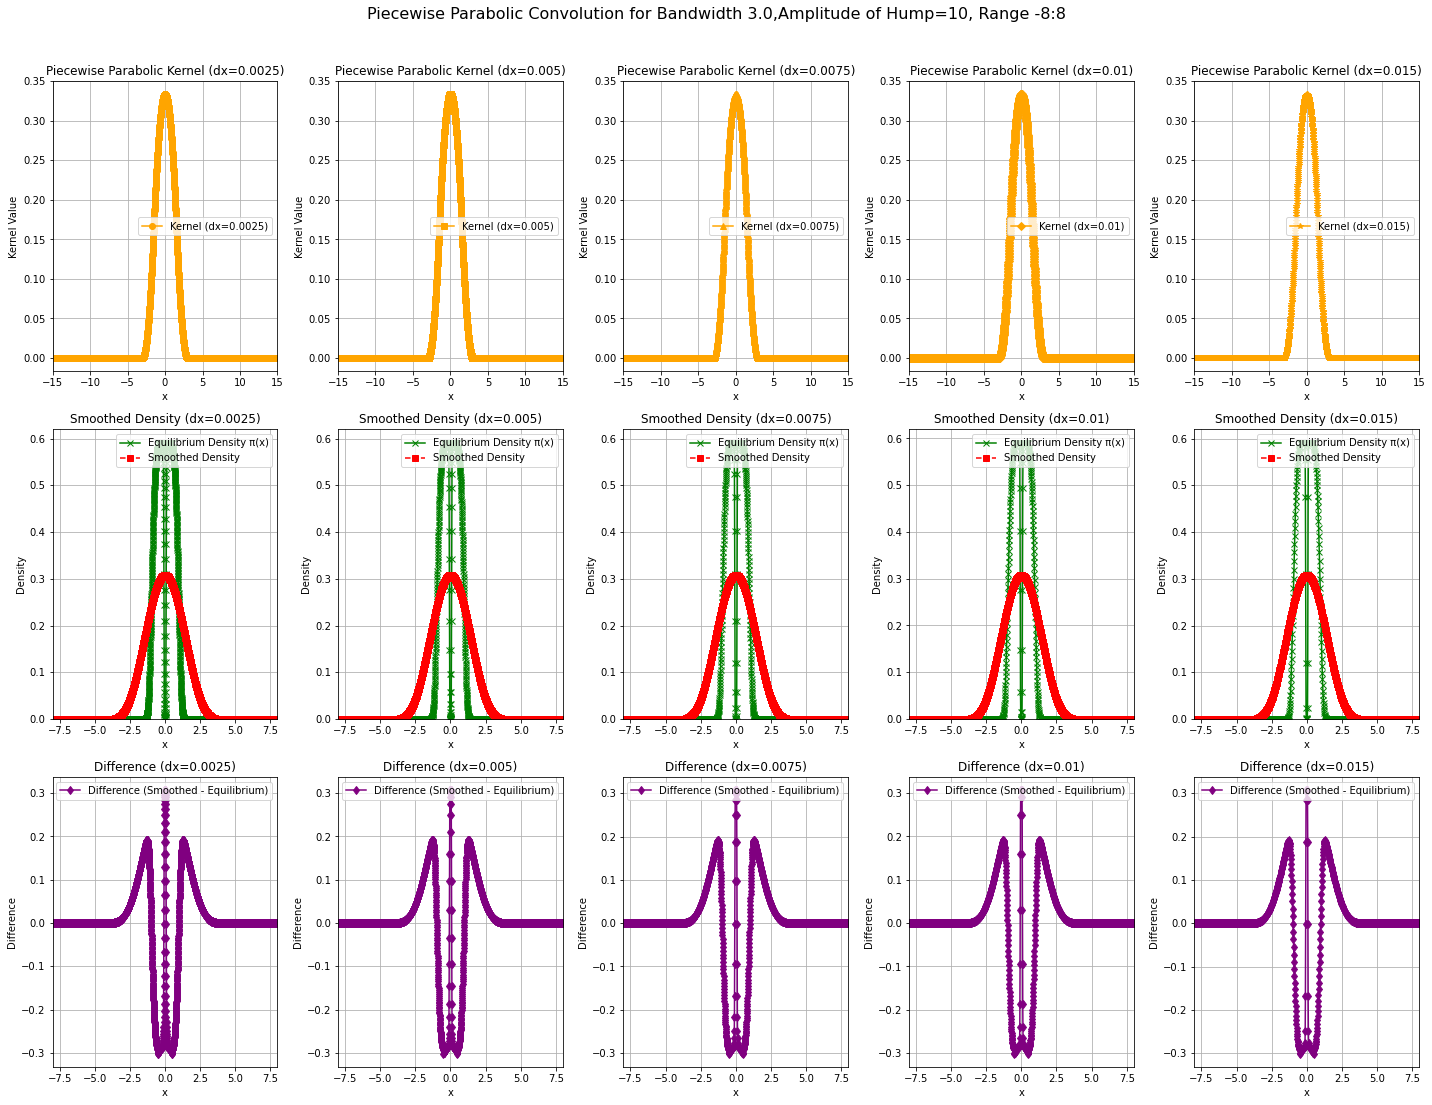

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# New 1D Potential Function with a reduced middle hump
def V(x, sigma_pot=0.05, y0=0.1, A=10.0, a=1.0, x_c=0.5):
    """
    Computes the 1D potential function mimicking the 2D entropic double-well potential.

    Parameters:
    - x: The position at which to evaluate the potential.
    - sigma_pot: The width of the barrier, controls the sharpness of the hump.
    - y0: The y-parameter of the original 2D potential, kept constant here.
    - A: Amplitude of the middle hump.
    - a: Scaling factor for the potential.
    - x_c: Critical value where the function transitions from inside to outside the barrier.

    Returns:
    - V(x): The potential value at position x.
    """
    if np.abs(x) > x_c:
        # Outside the barrier region; the potential grows like x^6
        return a * x**6
    else:
        # Inside the barrier region; use a Gaussian-like function to create the middle hump
        return A * np.exp(-(x/sigma_pot)**2) * (1 - np.exp(-(y0/sigma_pot)**2))

def piecewise_parabolic_kernel(x, sigma_kernel):
    """Piecewise Parabolic Kernel function."""
    if x <= -sigma_kernel or x >= sigma_kernel:
        return 0.0
    elif x <= -0.5 * sigma_kernel:
        kernel_value = 1.0 + x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 2.0 * kernel_value / sigma_kernel
    elif x >= 0.5 * sigma_kernel:
        kernel_value = 1.0 - x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 2.0 * kernel_value / sigma_kernel
    else:
        kernel_value = x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 1.0 - 2.0 * kernel_value
        kernel_value = kernel_value / sigma_kernel
    return kernel_value

def convolve_density(boltz_array, kernel_array, dx):
    """Perform convolution on the density array."""
    npoints_pot = len(boltz_array)
    npoints_kernel = len(kernel_array)
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half = (npoints_kernel - 1) // 2
    
    for kount in range(npoints_pot):
        for kount_kernel in range(npoints_kernel):
            kount_kernel_shifted = kount - kernel_half + kount_kernel
            if 0 <= kount_kernel_shifted < npoints_pot:
                boltz_array_conv[kount_kernel_shifted] += boltz_array[kount] * kernel_array[kount_kernel] * dx
    
    return boltz_array_conv

def plot_results(lattice_spacings, sigma_kernel, x_min, x_max):
    fig, axs = plt.subplots(3, len(lattice_spacings), figsize=(20, 15))
    
    # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    markers = ['o', 's', '^', 'D', '*']  # Different markers for different plots
    colors = ['orange', 'green', 'red', 'purple']  # Different colors for different plots

    for i, dx in enumerate(lattice_spacings):
        npoints_pot = int((x_max - x_min - 0.1 * dx) / dx) + 2
        x = np.linspace(x_min, x_max, npoints_pot)

        potential_array = np.array([V(xi) for xi in x])
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density using the trapezium rule
        boltz_array /= np.trapz(boltz_array, x)
        
        # Kernel and its convolution
        # Extend Kernel to cover 5*sigma_kernel
        kernel_size = int(5 * sigma_kernel)  # Extending kernel size
        npoints_kernel = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel = 2 * npoints_kernel + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel)
        kernel_array = np.array([piecewise_parabolic_kernel(kx, sigma_kernel) for kx in kernel_x])
        
        # Normalize the kernel using the trapezium rule
        kernel_array /= np.trapz(kernel_array, kernel_x)
        
        # Print out the integral of the kernel to check it sums to one
        kernel_integral = np.trapz(kernel_array, kernel_x)
        print(f"Integral of the Piecewise Parabolic Kernel for dx={dx}: {kernel_integral}")
        
        boltz_array_conv = convolve_density(boltz_array, kernel_array, dx)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Piecewise Parabolic Kernel
        axs[0, i].plot(kernel_x, kernel_array, label=f'Kernel (dx={dx})', color='orange', marker=markers[i % len(markers)])
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('Kernel Value')
        axs[0, i].set_title(f'Piecewise Parabolic Kernel (dx={dx})')
        axs[0, i].legend()
        axs[0, i].grid(True)
        axs[0, i].set_xlim(-kernel_size, kernel_size)
        
        # Plot Equilibrium Density and Smoothed Density
        axs[1, i].plot(x, boltz_array, label='Equilibrium Density π(x)', color='green', marker='x')
        axs[1, i].plot(x, boltz_array_conv, label='Smoothed Density', color='red', linestyle='--', marker='s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Density')
        axs[1, i].set_title(f'Smoothed Density (dx={dx})')
        axs[1, i].legend()
        axs[1, i].grid(True)
        axs[1, i].set_xlim(x_min, x_max)
        axs[1, i].set_ylim(bottom=0)  # Ensure densities start from zero
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[2, i].plot(x, density_difference, label='Difference (Smoothed - Equilibrium)', color='purple', marker='d')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('Difference')
        axs[2, i].set_title(f'Difference (dx={dx})')
        axs[2, i].legend()
        axs[2, i].grid(True)
        axs[2, i].set_xlim(x_min, x_max)

    # Add a main title to the figure
    fig.suptitle('Piecewise Parabolic Convolution for Bandwidth 3.0,Amplitude of Hump=10, Range -8:8', fontsize=16, y=1.02)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig('PPD_1d_2d_bw8_a10.png', dpi=300, bbox_inches='tight', facecolor='white')  # Ensure white background
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.0025, 0.005, 0.0075, 0.01, 0.015]  # Finer lattice spacings
    sigma_kernel = 3.0  # Fixed bandwidth for the kernel
    x_min, x_max = -8, 8  # Extend range to cover more of the density tail
    plot_results(lattice_spacings, sigma_kernel, x_min, x_max)


Integral of the Piecewise Parabolic Kernel for dx=0.0025: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.005: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.0075: 0.9999999999999999
Integral of the Piecewise Parabolic Kernel for dx=0.01: 1.0
Integral of the Piecewise Parabolic Kernel for dx=0.015: 1.0


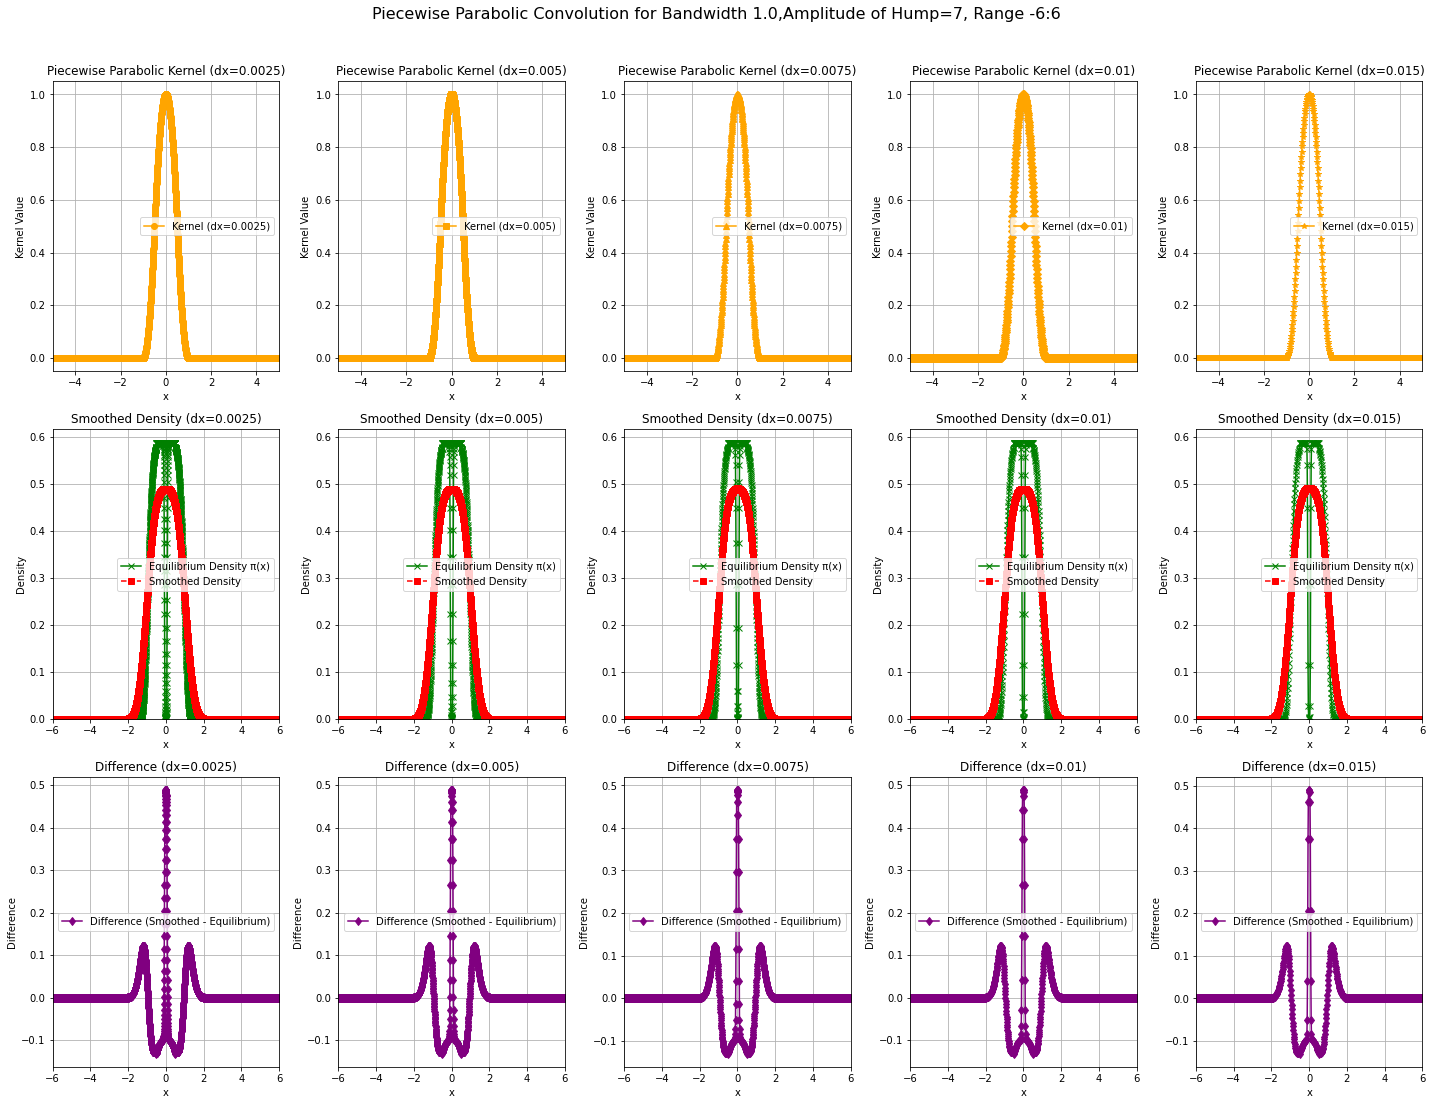

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# New 1D Potential Function with a reduced middle hump
def V(x, sigma_pot=0.05, y0=0.1, A=7.0, a=1.0, x_c=0.5):
    """
    Computes the 1D potential function mimicking the 2D entropic double-well potential.

    Parameters:
    - x: The position at which to evaluate the potential.
    - sigma_pot: The width of the barrier, controls the sharpness of the hump.
    - y0: The y-parameter of the original 2D potential, kept constant here.
    - A: Amplitude of the middle hump.
    - a: Scaling factor for the potential.
    - x_c: Critical value where the function transitions from inside to outside the barrier.

    Returns:
    - V(x): The potential value at position x.
    """
    if np.abs(x) > x_c:
        # Outside the barrier region; the potential grows like x^6
        return a * x**6
    else:
        # Inside the barrier region; use a Gaussian-like function to create the middle hump
        return A * np.exp(-(x/sigma_pot)**2) * (1 - np.exp(-(y0/sigma_pot)**2))

def piecewise_parabolic_kernel(x, sigma_kernel):
    """Piecewise Parabolic Kernel function."""
    if x <= -sigma_kernel or x >= sigma_kernel:
        return 0.0
    elif x <= -0.5 * sigma_kernel:
        kernel_value = 1.0 + x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 2.0 * kernel_value / sigma_kernel
    elif x >= 0.5 * sigma_kernel:
        kernel_value = 1.0 - x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 2.0 * kernel_value / sigma_kernel
    else:
        kernel_value = x / sigma_kernel
        kernel_value = kernel_value**2
        kernel_value = 1.0 - 2.0 * kernel_value
        kernel_value = kernel_value / sigma_kernel
    return kernel_value

def convolve_density(boltz_array, kernel_array, dx):
    """Perform convolution on the density array."""
    npoints_pot = len(boltz_array)
    npoints_kernel = len(kernel_array)
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half = (npoints_kernel - 1) // 2
    
    for kount in range(npoints_pot):
        for kount_kernel in range(npoints_kernel):
            kount_kernel_shifted = kount - kernel_half + kount_kernel
            if 0 <= kount_kernel_shifted < npoints_pot:
                boltz_array_conv[kount_kernel_shifted] += boltz_array[kount] * kernel_array[kount_kernel] * dx
    
    return boltz_array_conv

def plot_results(lattice_spacings, sigma_kernel, x_min, x_max):
    fig, axs = plt.subplots(3, len(lattice_spacings), figsize=(20, 15))
    
    # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    markers = ['o', 's', '^', 'D', '*']  # Different markers for different plots
    colors = ['orange', 'green', 'red', 'purple']  # Different colors for different plots

    for i, dx in enumerate(lattice_spacings):
        npoints_pot = int((x_max - x_min - 0.1 * dx) / dx) + 2
        x = np.linspace(x_min, x_max, npoints_pot)

        potential_array = np.array([V(xi) for xi in x])
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density using the trapezium rule
        boltz_array /= np.trapz(boltz_array, x)
        
        # Kernel and its convolution
        # Extend Kernel to cover 5*sigma_kernel
        kernel_size = int(5 * sigma_kernel)  # Extending kernel size
        npoints_kernel = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel = 2 * npoints_kernel + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel)
        kernel_array = np.array([piecewise_parabolic_kernel(kx, sigma_kernel) for kx in kernel_x])
        
        # Normalize the kernel using the trapezium rule
        kernel_array /= np.trapz(kernel_array, kernel_x)
        
        # Print out the integral of the kernel to check it sums to one
        kernel_integral = np.trapz(kernel_array, kernel_x)
        print(f"Integral of the Piecewise Parabolic Kernel for dx={dx}: {kernel_integral}")
        
        boltz_array_conv = convolve_density(boltz_array, kernel_array, dx)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Piecewise Parabolic Kernel
        axs[0, i].plot(kernel_x, kernel_array, label=f'Kernel (dx={dx})', color='orange', marker=markers[i % len(markers)])
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('Kernel Value')
        axs[0, i].set_title(f'Piecewise Parabolic Kernel (dx={dx})')
        axs[0, i].legend()
        axs[0, i].grid(True)
        axs[0, i].set_xlim(-kernel_size, kernel_size)
        
        # Plot Equilibrium Density and Smoothed Density
        axs[1, i].plot(x, boltz_array, label='Equilibrium Density π(x)', color='green', marker='x')
        axs[1, i].plot(x, boltz_array_conv, label='Smoothed Density', color='red', linestyle='--', marker='s')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('Density')
        axs[1, i].set_title(f'Smoothed Density (dx={dx})')
        axs[1, i].legend()
        axs[1, i].grid(True)
        axs[1, i].set_xlim(x_min, x_max)
        axs[1, i].set_ylim(bottom=0)  # Ensure densities start from zero
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[2, i].plot(x, density_difference, label='Difference (Smoothed - Equilibrium)', color='purple', marker='d')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('Difference')
        axs[2, i].set_title(f'Difference (dx={dx})')
        axs[2, i].legend()
        axs[2, i].grid(True)
        axs[2, i].set_xlim(x_min, x_max)

    # Add a main title to the figure
    fig.suptitle('Piecewise Parabolic Convolution for Bandwidth 1.0,Amplitude of Hump=7, Range -6:6', fontsize=16, y=1.02)
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig('PPD_1d_2d_bw1_a7.png', dpi=300, bbox_inches='tight', facecolor='white')  # Ensure white background
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.0025, 0.005, 0.0075, 0.01, 0.015]  # Finer lattice spacings
    sigma_kernel = 1.0  # Fixed bandwidth for the kernel
    x_min, x_max = -6, 6  # Extend range to cover more of the density tail
    plot_results(lattice_spacings, sigma_kernel, x_min, x_max)
